In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd "/content/drive/MyDrive/DS1final/code"

Mounted at /content/drive
/content/drive/MyDrive/DS1final/code


In [2]:
import pandas as pd
import numpy as np

from itertools import combinations

! pip install sweetviz 
import sweetviz as sv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.1 MB 5.2 MB/s 


# load and merge data

load all datas

In [3]:
# !ls "../Dataset/NCES"

In [4]:
path = "../Dataset/"

## NCES data

financial columns we need:
* pp_total_raw_DC: per-pupil total expenditure total
* pp_site_raw_DC: per-pupil site expenditure total
* pp_centshare_raw_DC: per-pupil site-share of central expenditure total
* schoolstloc_raw_DC: total school state and local expenditures (not per-pupil)
* schtype_raw_DC: school type

In [5]:
def nces_process(data):

    # get columns we need
    cols = data.columns
    finan_cols =  ['pp_total_raw_DC', 'pp_site_raw_DC', 'pp_centshare_raw_DC', 'schoolstloc_raw_DC', \
                    'schtype_raw_DC']
    other_cols = ['level', 'enroll_raw_DC']
    if 'nces_freelunch' in data:
        other_cols += ['nces_freelunch', 'nces_reducedlunch']
        
    cols_need = list(cols[0:6]) + finan_cols + other_cols
    data = data[cols_need]

    #delete cols have constant value except state and year
    drop_cols = list(data.columns[data.nunique() <= 1])[2:] 
    data = data.drop(drop_cols, axis=1)

    #transfer col to some numeric data and fill null w/ empty value
    num_cols = ['enroll_raw_DC', 'schoolstloc_raw_DC'] + \
                [col for col in data if col.startswith('pp')]
    for col in num_cols:
        data[col] = pd.to_numeric( data[col], errors='coerce')
    

    return data

In [6]:
nces_1819 = pd.read_excel("../Dataset/NCES/DC_1819.xlsx")
nces_1819.columns

Index(['state', 'year', 'distid_stateassigned', 'schoolid_stateassigned',
       'distname', 'schoolname', 'ncesdistid_admin', 'ncesdistid_geo',
       'census_id', 'ncesid', 'ncesenroll', 'gradespan', 'level',
       'enroll_raw_DC', 'enrollmetric', 'pp_stloc_raw_DC', 'pp_fed_raw_DC',
       'pp_total_raw_DC', 'pp_site_stloc_raw_DC', 'pp_site_fed_raw_DC',
       'pp_site_raw_DC', 'pp_centshare_stloc_raw_DC',
       'pp_centshare_fed_raw_DC', 'pp_centshare_raw_DC', 'schoolstloc_raw_DC',
       'schoolfed_raw_DC', 'schooltot_raw_DC', 'pp_total_norm_NERDS',
       'disttotwexclu_raw_DC', 'distexclu_raw_DC', 'schtype_raw_DC',
       'ward_raw_DC', 'countenroll', 'noaudit', 'nositecen', 'adfinvars',
       'distflex', 'flag_nerds', 'flag_f33'],
      dtype='object')

                                             |          | [  0%]   00:00 -> (? left)


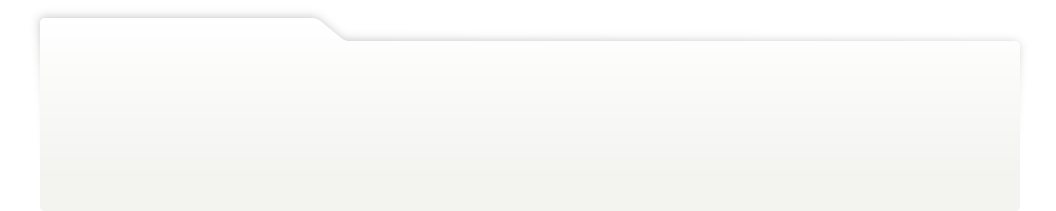
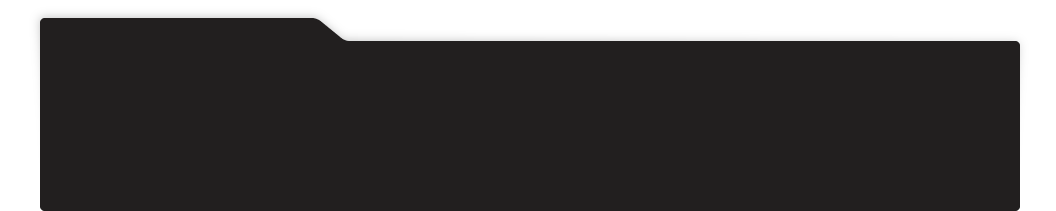
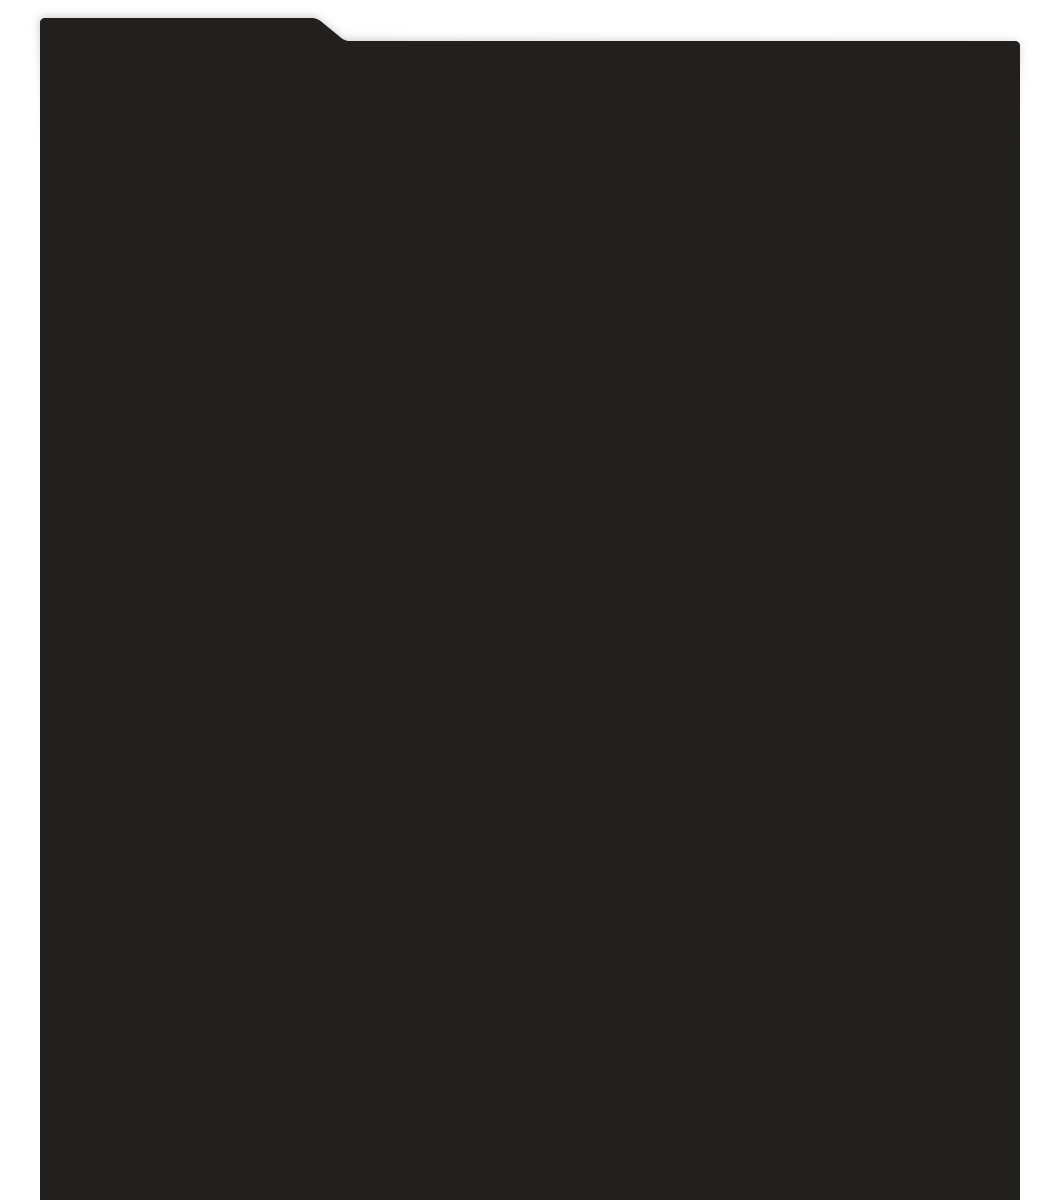
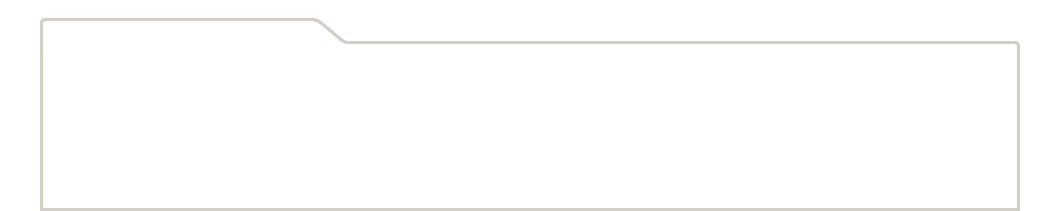
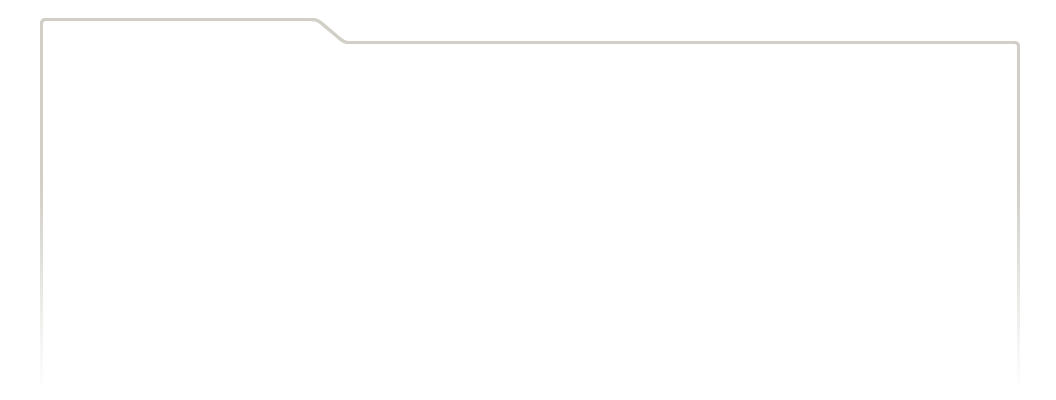
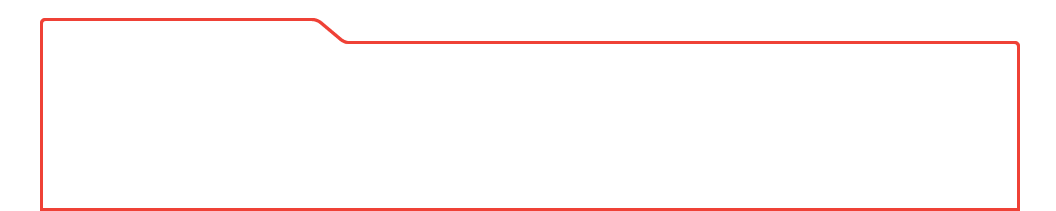
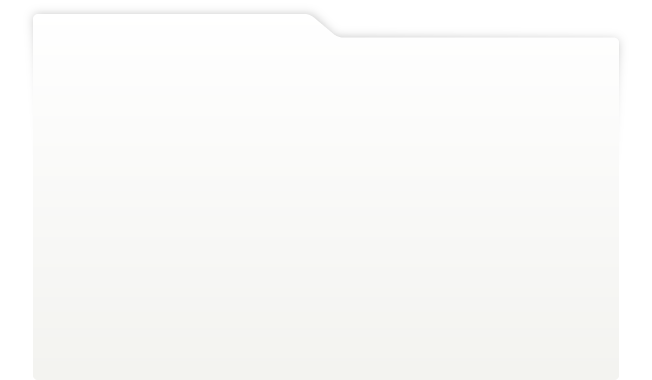
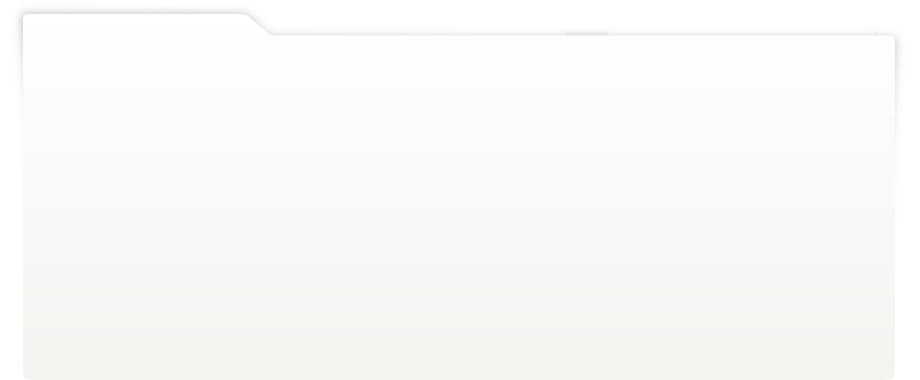
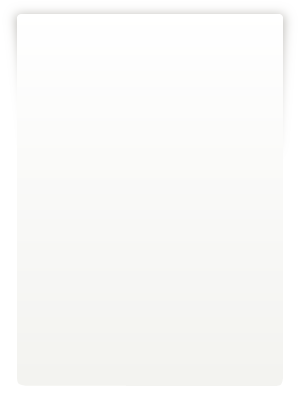
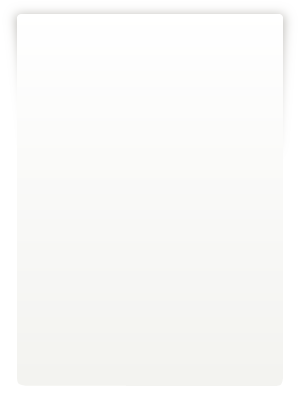
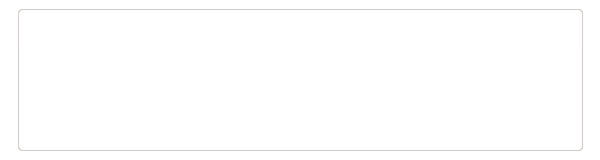
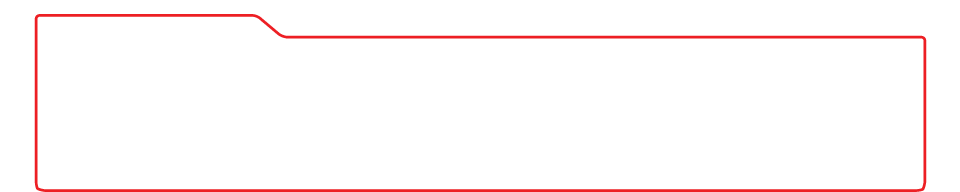
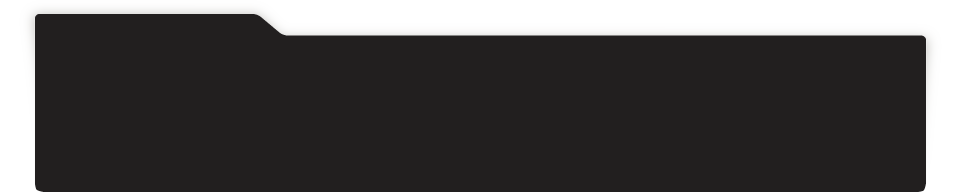
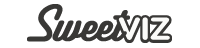
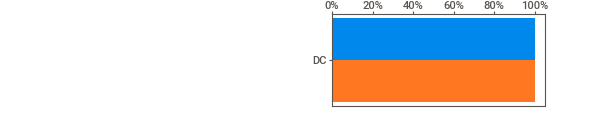
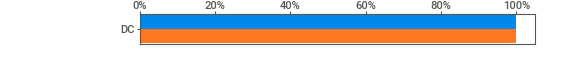
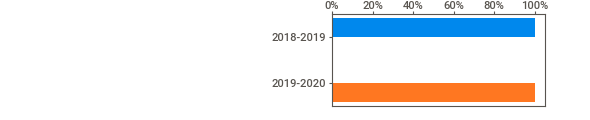
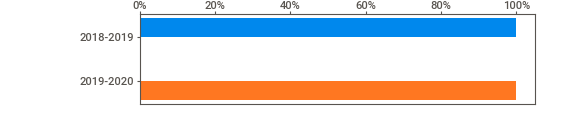
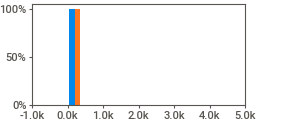
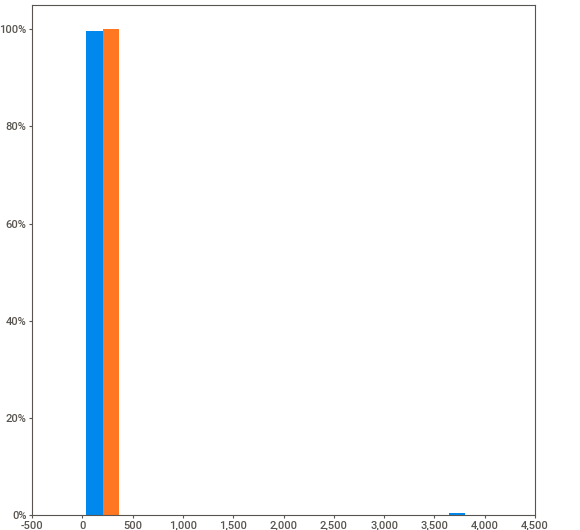
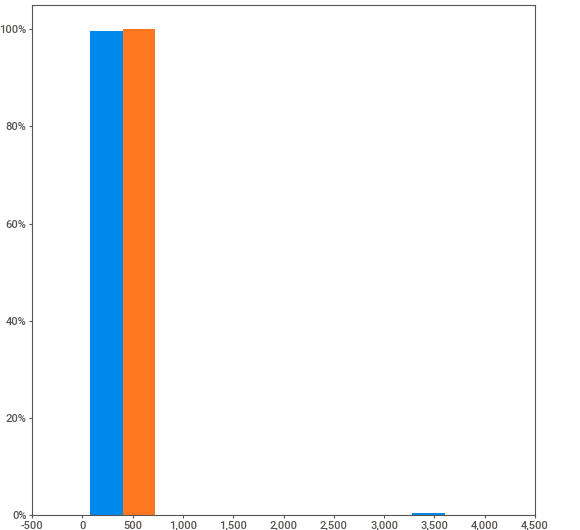
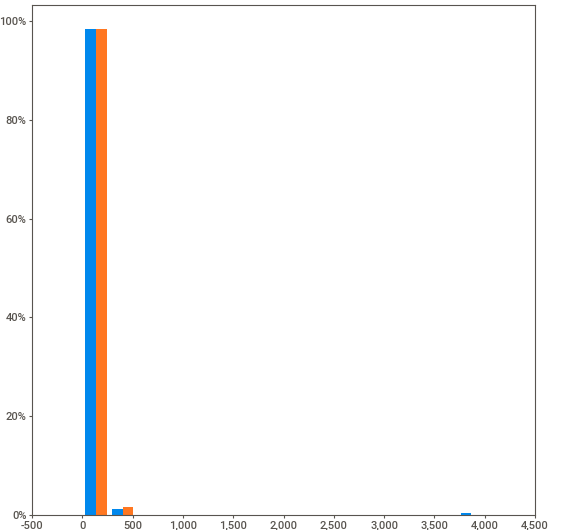
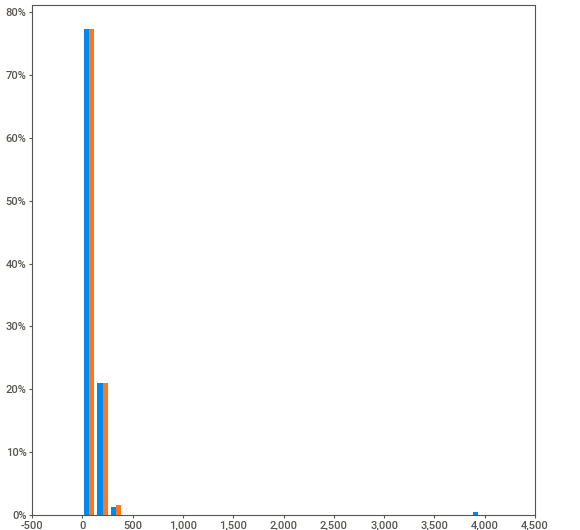
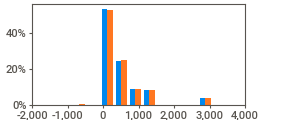
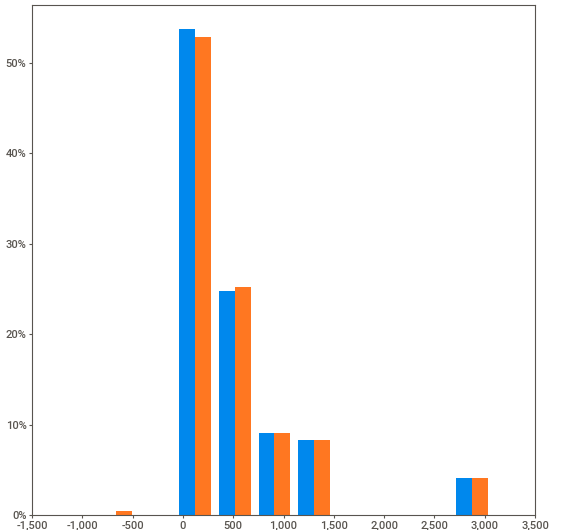
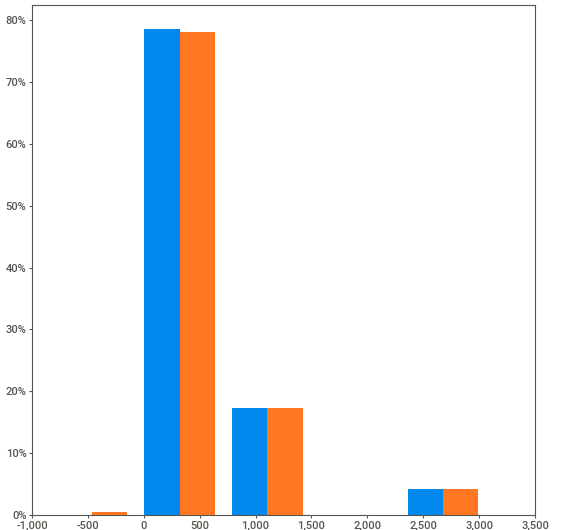
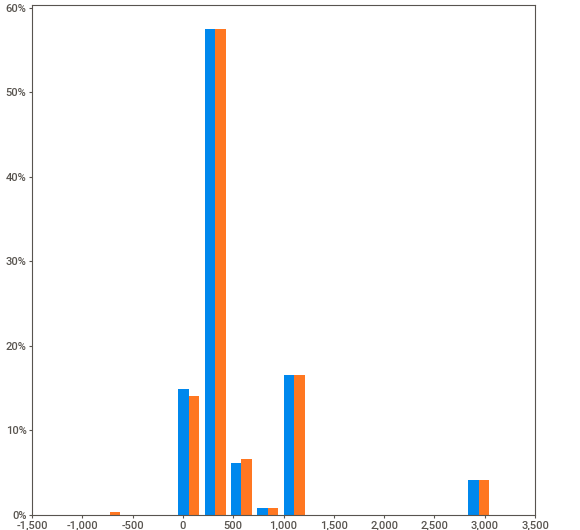
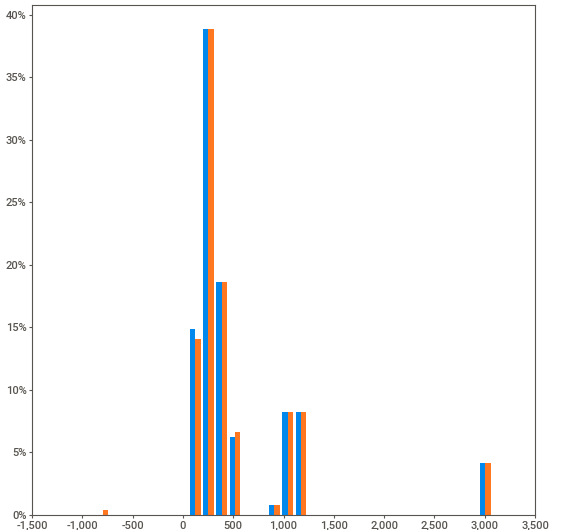
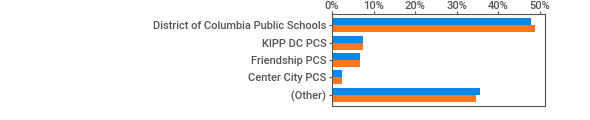
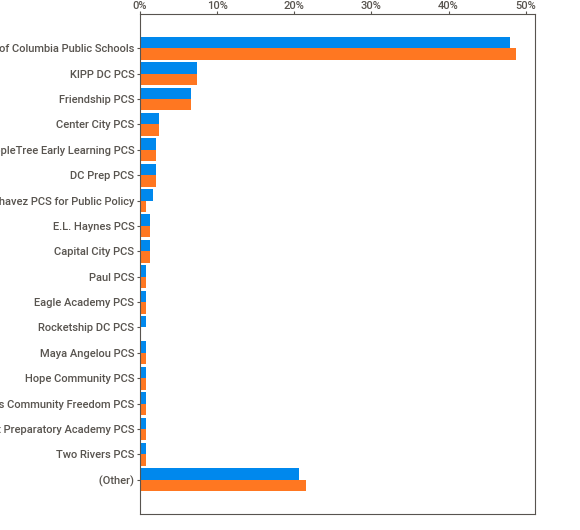
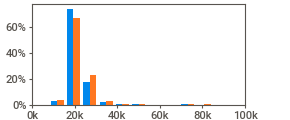
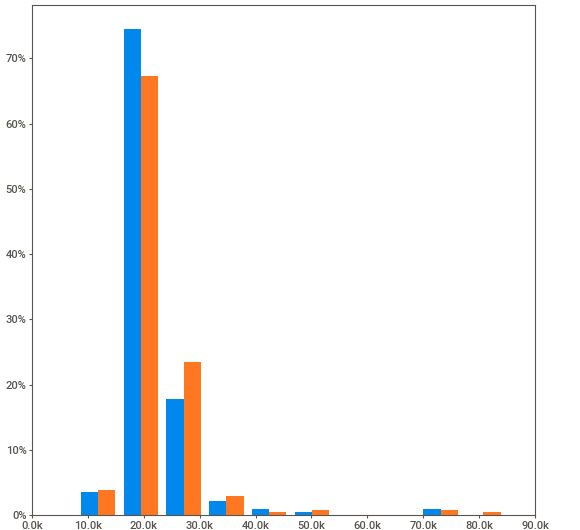
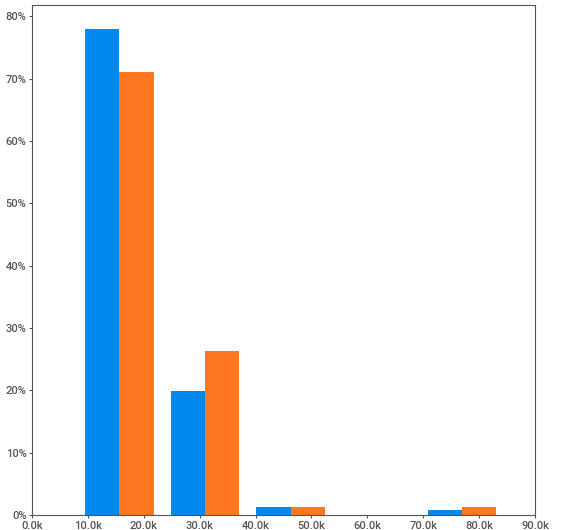
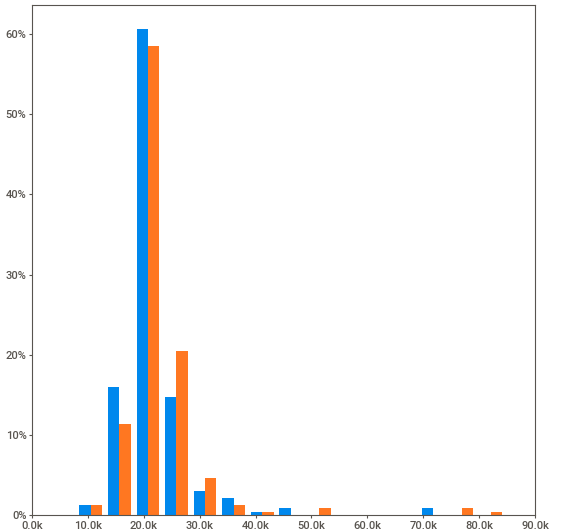
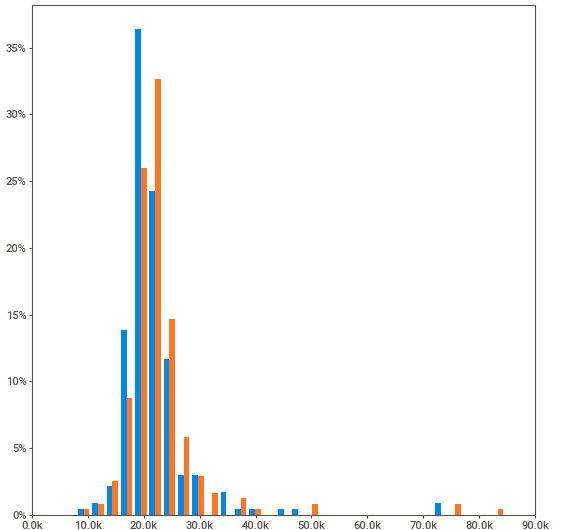
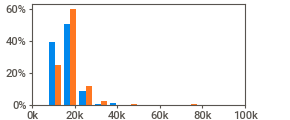
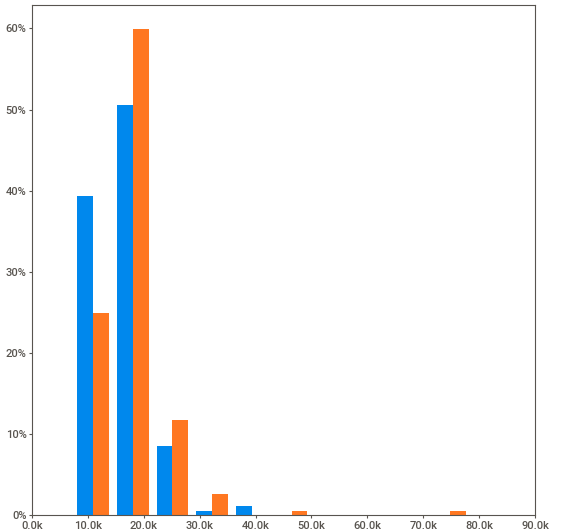
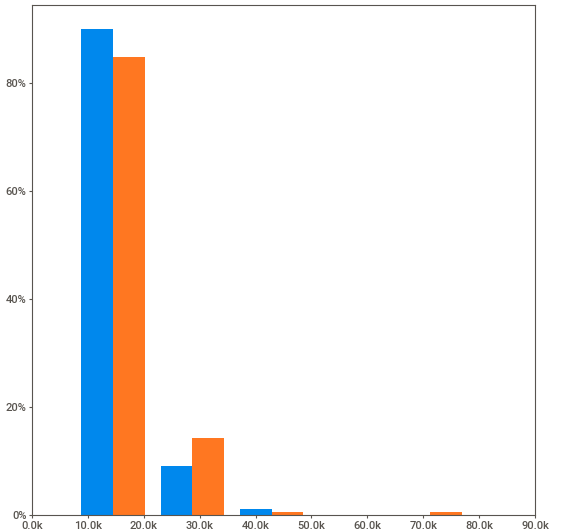
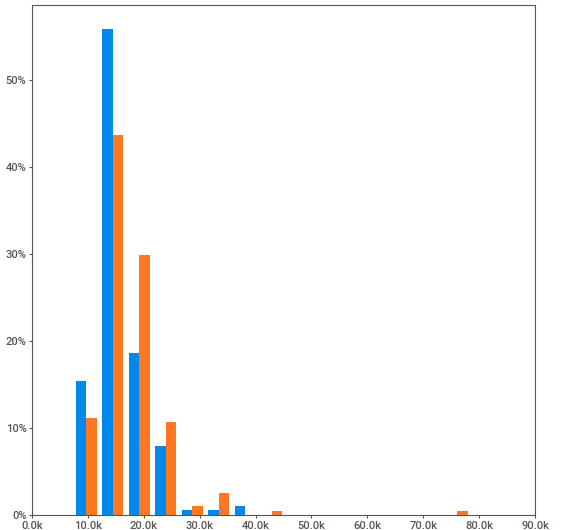
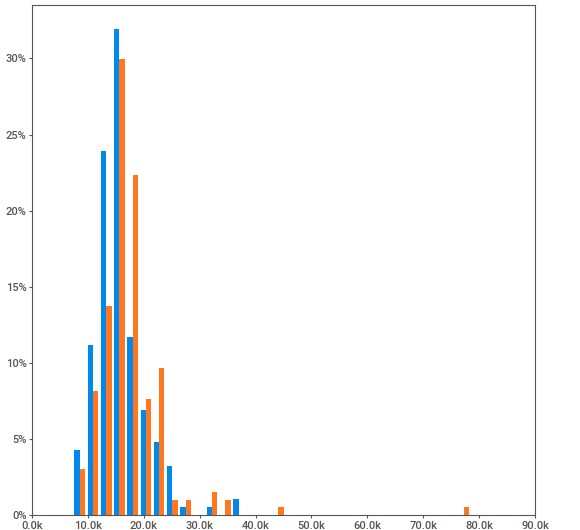
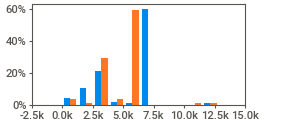
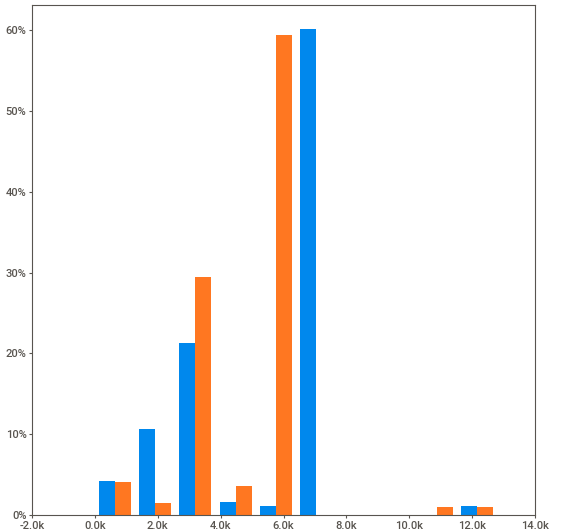
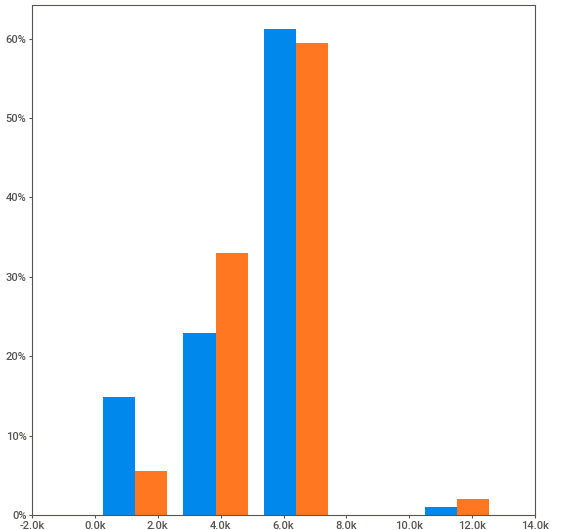
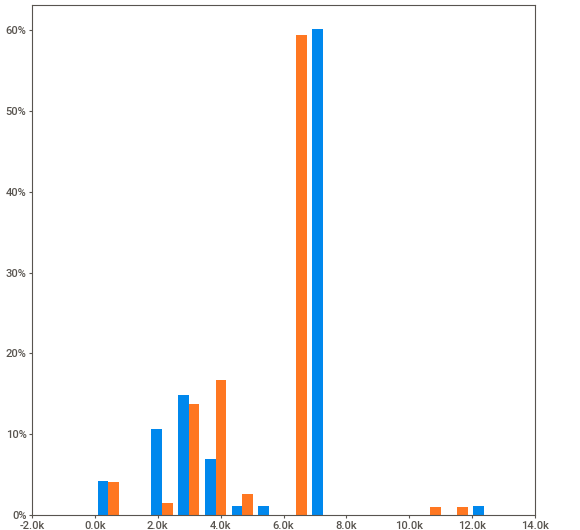
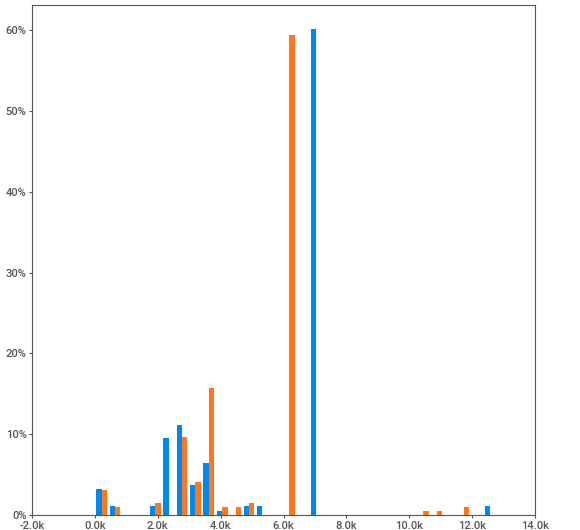
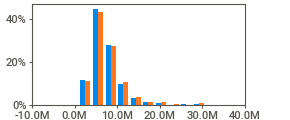
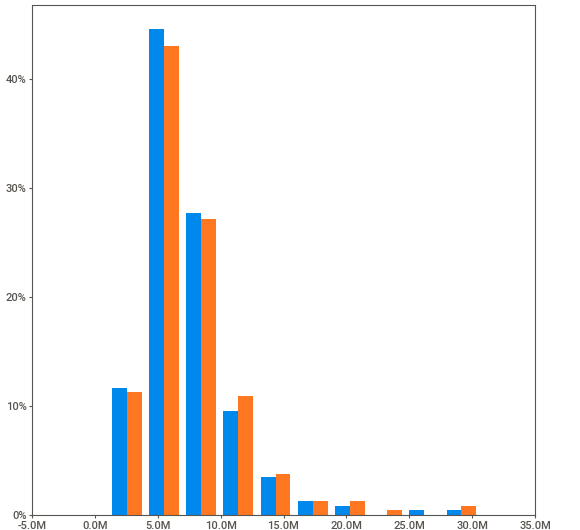
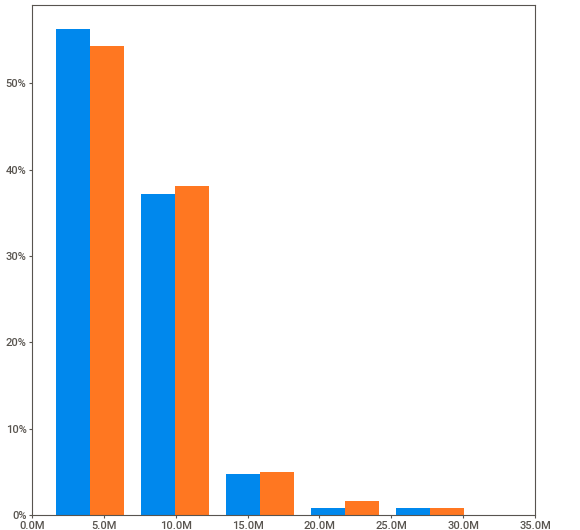
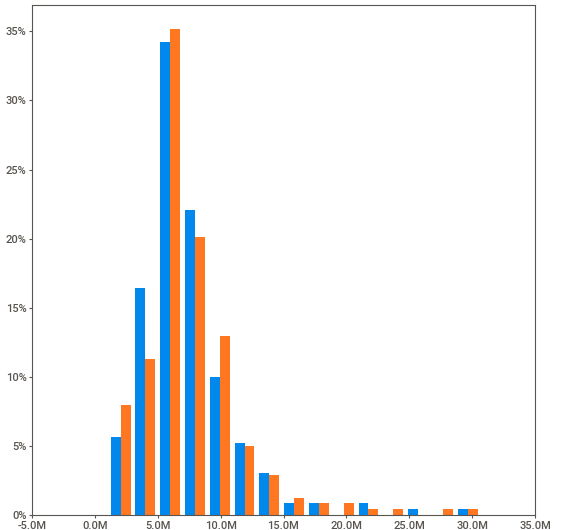
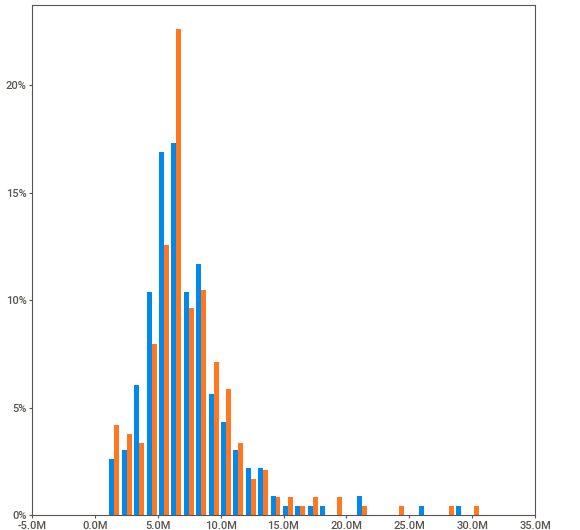
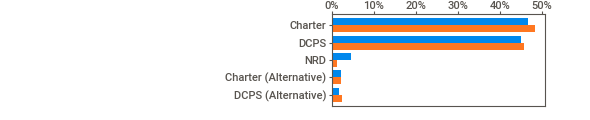
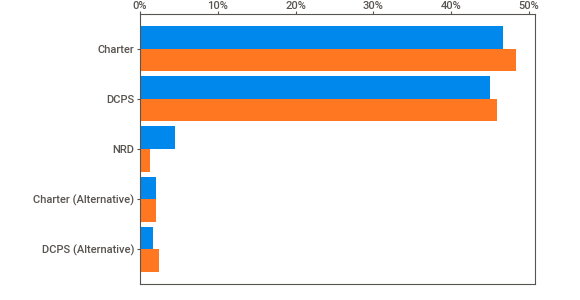
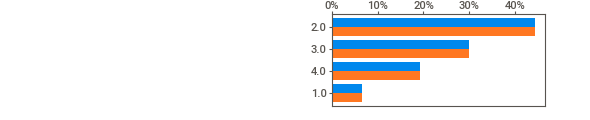
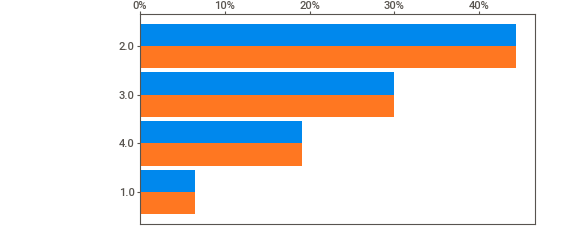
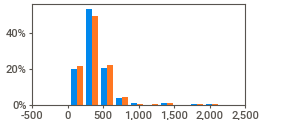
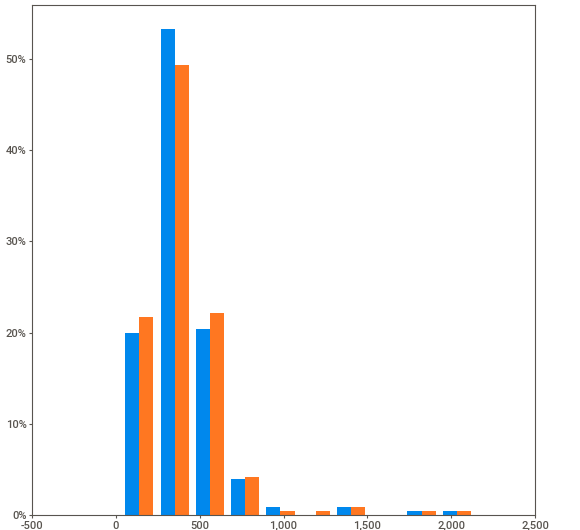
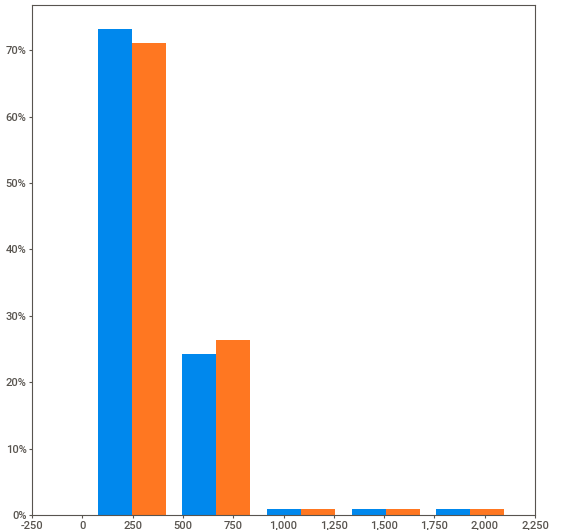
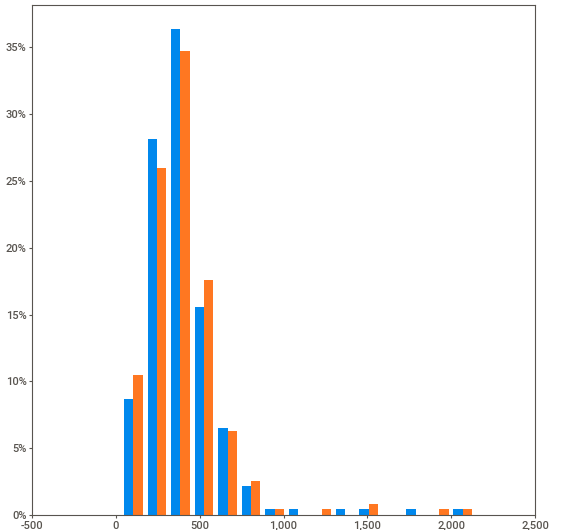
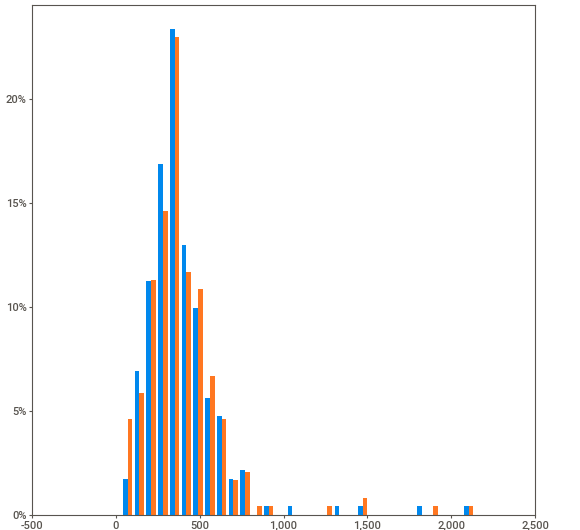
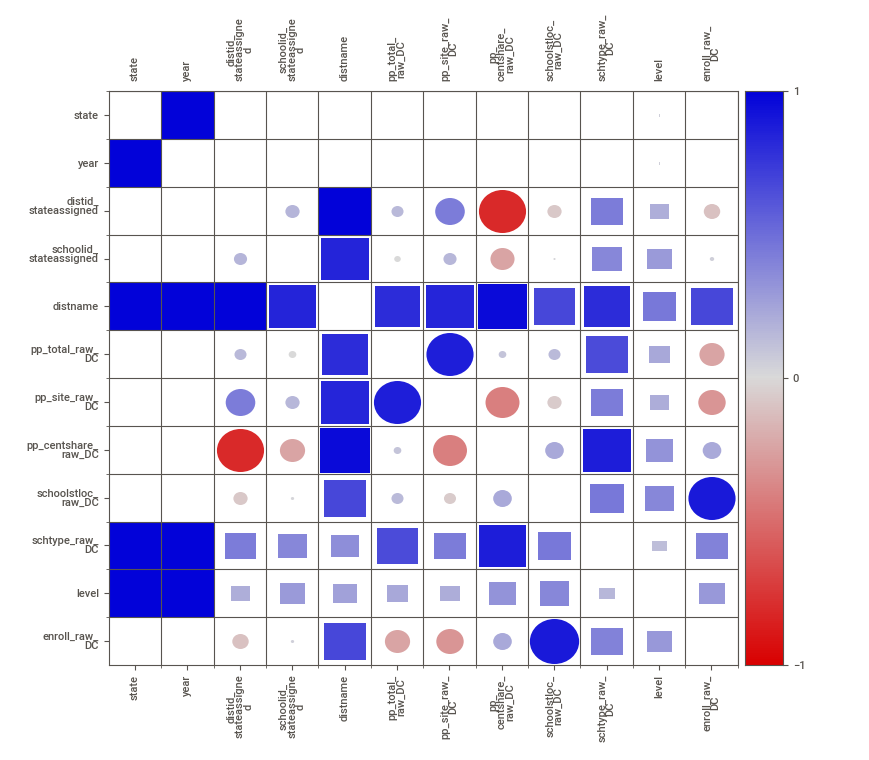
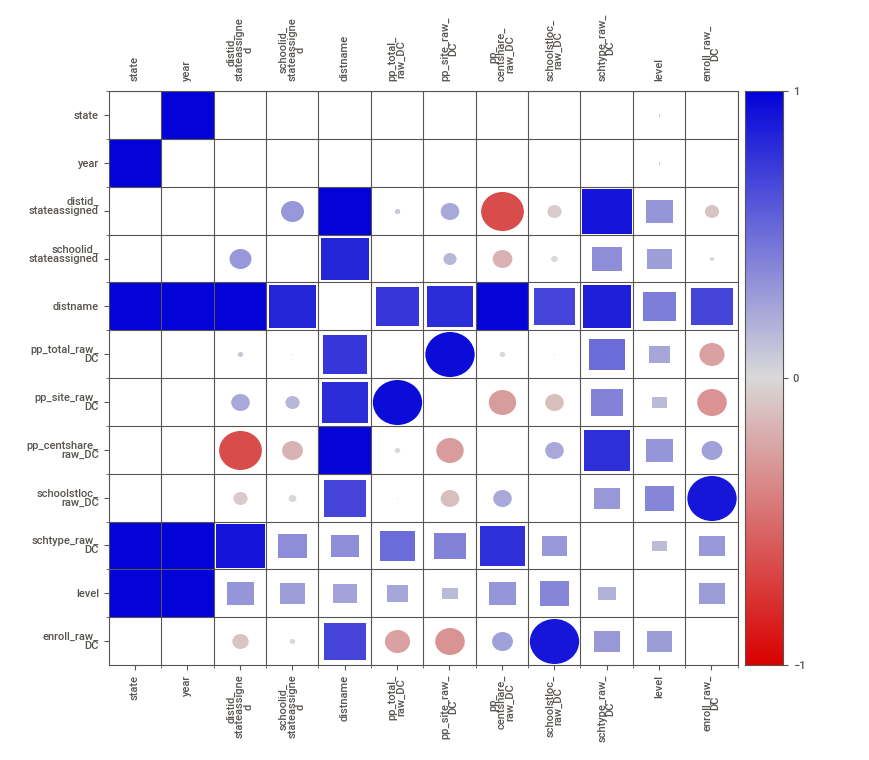

In [7]:
nces_1819 = pd.read_excel("../Dataset/NCES/DC_1819.xlsx")
nces_1819 = nces_process(nces_1819)
nces_1920=pd.read_excel("../Dataset/NCES/DC_1920.xlsx")
nces_1920 = nces_process(nces_1920)

nces_cmp = sv.compare(nces_1819, nces_1920)
nces_cmp.show_notebook()

In [8]:
nces_1819.columns

Index(['state', 'year', 'distid_stateassigned', 'schoolid_stateassigned',
       'distname', 'schoolname', 'pp_total_raw_DC', 'pp_site_raw_DC',
       'pp_centshare_raw_DC', 'schoolstloc_raw_DC', 'schtype_raw_DC', 'level',
       'enroll_raw_DC'],
      dtype='object')

### merge data and preprocess for data after merge

In [9]:
nces = nces_1819.merge(nces_1920, on='schoolid_stateassigned', suffixes=("_1819", "_1920"))
print(nces_1819.shape, nces_1920.shape)
print(nces.shape)
nces.columns

(242, 13) (242, 13)
(239, 25)


Index(['state_1819', 'year_1819', 'distid_stateassigned_1819',
       'schoolid_stateassigned', 'distname_1819', 'schoolname_1819',
       'pp_total_raw_DC_1819', 'pp_site_raw_DC_1819',
       'pp_centshare_raw_DC_1819', 'schoolstloc_raw_DC_1819',
       'schtype_raw_DC_1819', 'level_1819', 'enroll_raw_DC_1819', 'state_1920',
       'year_1920', 'distid_stateassigned_1920', 'distname_1920',
       'schoolname_1920', 'pp_total_raw_DC_1920', 'pp_site_raw_DC_1920',
       'pp_centshare_raw_DC_1920', 'schoolstloc_raw_DC_1920',
       'schtype_raw_DC_1920', 'level_1920', 'enroll_raw_DC_1920'],
      dtype='object')

In [10]:
nces[nces.schtype_raw_DC_1920 != nces.schtype_raw_DC_1819][['schtype_raw_DC_1819', 'schtype_raw_DC_1920']]

,schtype_raw_DC_1819,schtype_raw_DC_1920
42,NRD,DCPS
80,NRD,DCPS
161,NRD,Charter
167,NRD,Charter
168,NRD,Charter
192,NRD,Charter
199,NRD,Charter
206,NRD,Charter
213,NRD,Charter
214,Charter,NRD


In [11]:
nces[nces.schtype_raw_DC_1920 == 'NRD']['schtype_raw_DC_1920'] = np.nan
nces[nces.schtype_raw_DC_1819 == 'NRD']['schtype_raw_DC_1920'] = np.nan
nces['schtype_raw_DC'] = nces['schtype_raw_DC_1819'].fillna(nces['schtype_raw_DC_1920'])
nces['schtype_raw_DC'].isnull().sum()
nces.columns

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Index(['state_1819', 'year_1819', 'distid_stateassigned_1819',
       'schoolid_stateassigned', 'distname_1819', 'schoolname_1819',
       'pp_total_raw_DC_1819', 'pp_site_raw_DC_1819',
       'pp_centshare_raw_DC_1819', 'schoolstloc_raw_DC_1819',
       'schtype_raw_DC_1819', 'level_1819', 'enroll_raw_DC_1819', 'state_1920',
       'year_1920', 'distid_stateassigned_1920', 'distname_1920',
       'schoolname_1920', 'pp_total_raw_DC_1920', 'pp_site_raw_DC_1920',
       'pp_centshare_raw_DC_1920', 'schoolstloc_raw_DC_1920',
       'schtype_raw_DC_1920', 'level_1920', 'enroll_raw_DC_1920',
       'schtype_raw_DC'],
      dtype='object')

In [12]:
nces = nces.drop(['state_1819', 'distid_stateassigned_1920', 'distname_1920', 'state_1920', 'level_1920', 'schoolname_1920', 'schtype_raw_DC_1819', 'schtype_raw_DC_1920'], axis=1)
nces.rename(columns = {'distid_stateassigned_1819':'distid_stateassigned', 'distname_1819':'distname', 'schoolname_1819': 'schoolname', 'level_1819':'level'}, inplace = True)
col_reorder = ['schoolid_stateassigned', 'schoolname', 'level', 'schtype_raw_DC', 'distid_stateassigned', 'distname', 
               'year_1819','pp_total_raw_DC_1819', 'pp_site_raw_DC_1819',
               'pp_centshare_raw_DC_1819', 'schoolstloc_raw_DC_1819','enroll_raw_DC_1819', 
               'year_1920', 'pp_total_raw_DC_1920',
               'pp_site_raw_DC_1920', 'pp_centshare_raw_DC_1920',
               'schoolstloc_raw_DC_1920',  'enroll_raw_DC_1920']
nces = nces[col_reorder] 

nces.head()

,schoolid_stateassigned,schoolname,level,schtype_raw_DC,distid_stateassigned,distname,year_1819,pp_total_raw_DC_1819,pp_site_raw_DC_1819,pp_centshare_raw_DC_1819,schoolstloc_raw_DC_1819,enroll_raw_DC_1819,year_1920,pp_total_raw_DC_1920,pp_site_raw_DC_1920,pp_centshare_raw_DC_1920,schoolstloc_raw_DC_1920,enroll_raw_DC_1920
0,233,Academy of Hope Adult PCS,NaN,Charter,178,Academy of Hope Adult PCS,2018-2019,14478.0,NaN,NaN,6199570.0,463.0,2019-2020,14670.0,NaN,NaN,5566158.0,486.0
1,217,Achievement Preparatory Academy PCS - Wahler P...,2.0,Charter,155,Achievement Preparatory Academy PCS,2018-2019,22085.0,18270.0,3815.0,7525500.0,375.0,2019-2020,19357.0,8764.0,10593.0,6333696.0,384.0
2,1100,Achievement Preparatory Academy PCS - Wahler P...,3.0,Charter,155,Achievement Preparatory Academy PCS,2018-2019,17575.0,13403.0,4171.0,6951600.0,450.0,2019-2020,21630.0,10708.0,10922.0,6652869.0,361.0
3,140,AppleTree Early Learning Center PCS - Columbia...,1.0,Charter,103,AppleTree Early Learning PCS,2018-2019,20263.0,16917.0,3346.0,2864400.0,154.0,2019-2020,21271.0,17668.0,3603.0,2409036.0,147.0
4,3072,AppleTree Early Learning Center PCS - Douglas ...,1.0,Charter,103,AppleTree Early Learning PCS,2018-2019,19798.0,16453.0,3346.0,1566270.0,90.0,2019-2020,20762.0,17159.0,3603.0,1356805.0,89.0


## STAR

In [13]:
!ls "../Dataset/OSSEDC/2019"


'2019 DC School Report Card Aggregate Public Data_.xlsx'
'2019 Report Card_School Finance Public File.xlsx'


In [14]:
star_19 = pd.read_excel("../Dataset/OSSEDC/2019/2019 DC School Report Card Aggregate Public Data_.xlsx", sheet_name='STAR Scores')
star_18 = pd.read_csv('../Dataset/OSSEDC/2018/2018_School_STAR_Scores.csv')  
print(star_19.info())
print(star_18.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   LEA Code     206 non-null    int64  
 1   LEA Name     206 non-null    object 
 2   School Code  206 non-null    int64  
 3   School Name  206 non-null    object 
 4   School Type  206 non-null    object 
 5   Ward         206 non-null    int64  
 6   STAR Score   206 non-null    float64
 7   STAR Rating  206 non-null    int64  
 8   School Year  206 non-null    int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 14.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203 entries, 0 to 202
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   LEA_Code     203 non-null    int64  
 1   LEA_Name     203 non-null    object 
 2   School_Code  203 non-null    int64  
 3   School_Name  203 non-null    object 
 4   Schoo

In [15]:
star_19.columns = star_19.columns.str.replace(" ", "_")
star_19 = star_19.drop(['School_Year'], axis=1)
star_18 = star_18.drop(['ObjectId'], axis=1)
print(star_19.info())
print(star_18.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   LEA_Code     206 non-null    int64  
 1   LEA_Name     206 non-null    object 
 2   School_Code  206 non-null    int64  
 3   School_Name  206 non-null    object 
 4   School_Type  206 non-null    object 
 5   Ward         206 non-null    int64  
 6   STAR_Score   206 non-null    float64
 7   STAR_Rating  206 non-null    int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 13.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203 entries, 0 to 202
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   LEA_Code     203 non-null    int64  
 1   LEA_Name     203 non-null    object 
 2   School_Code  203 non-null    int64  
 3   School_Name  203 non-null    object 
 4   School_Type  203 non-null    object 
 5   Ward 

In [16]:
star = star_18[['School_Code', 'STAR_Score', 'STAR_Rating']].merge(star_19[['School_Code', 'STAR_Score', 'STAR_Rating']], on='School_Code', suffixes=('_18', '_19'))
star.head() 

,School_Code,STAR_Score_18,STAR_Rating_18,STAR_Score_19,STAR_Rating_19
0,101,48.21,3,56.83,3
1,102,35.63,2,38.37,2
2,109,47.68,3,39.89,2
3,113,35.96,2,57.43,3
4,114,51.40,3,44.31,3


In [17]:
# star_cmp = sv.compare(star_19, star_18)
# star_cmp.show_notebook()

## diversity data


In [18]:
# racial_1819 = pd.read_excel("../Dataset/school_spending/Diversity-Scores-for-DC-Schools_2018-19.xlsx", sheet_name='Racial and ethnic')
diversity = pd.read_excel("../Dataset/school_spending/Diversity-Scores-for-DC-Schools_2018-19.xlsx", sheet_name='Socioeconomic')
# print(racial_1819.info())
print(diversity.info())
diversity.columns = diversity.columns.str.replace(" ", "_")
print(diversity.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 14 columns):
 #   Column                                                                               Non-Null Count  Dtype  
---  ------                                                                               --------------  -----  
 0   LEA Code                                                                             216 non-null    int64  
 1   LEA Name                                                                             216 non-null    object 
 2   School Code                                                                          216 non-null    int64  
 3   School Name                                                                          216 non-null    object 
 4   Entity Type                                                                          216 non-null    object 
 5   Ward                                                                                 216 non

In [19]:
# racial_1819.columns = racial_1819.columns.str.replace(" ", "_")
# soc_econ_1819.columns = soc_econ_1819.columns.str.replace(" ", "_")
# print(racial_1819.isnull().sum())
# print(soc_econ_1819.isnull().sum())

In [20]:
# cols_to_use = list(racial_1819.columns.difference(soc_econ_1819.columns))
# diversity = soc_econ_1819.merge(racial_1819[cols_to_use+['School_Code']],  on=['School_Code'])
# diversity.head()

### set label 1-5 according to school's risk percentage

1: low risk -> 5: highrisk

In [21]:
bins= [0,20,40,60, 80,100]
labels = [1, 2, 3, 4, 5]
diversity['risk_level'] = pd.cut(diversity['At-Risk_(%)'], bins=bins, labels=labels, right=False)
diversity['risk_level'].value_counts()

3    64
4    59
1    37
2    33
5    23
Name: risk_level, dtype: int64

In [22]:
diversity.to_csv("../Dataset/final_data/diversity.csv")

                                             |          | [  0%]   00:00 -> (? left)


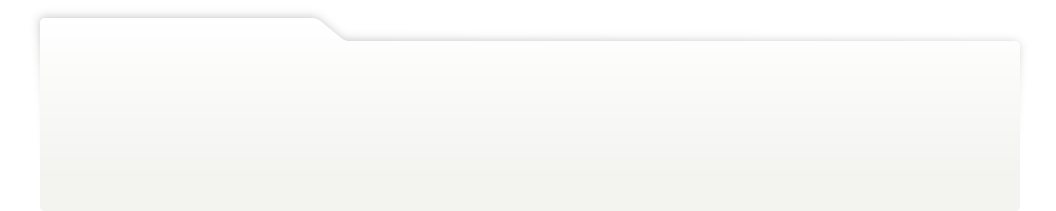
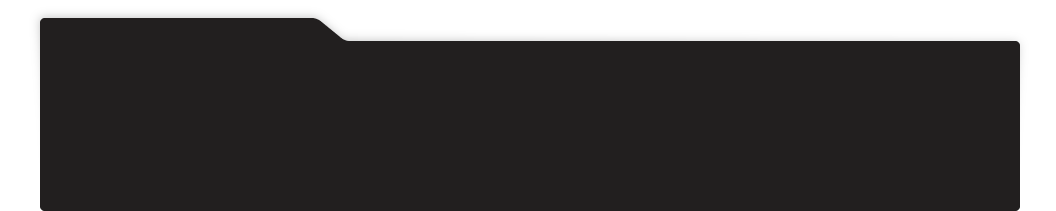
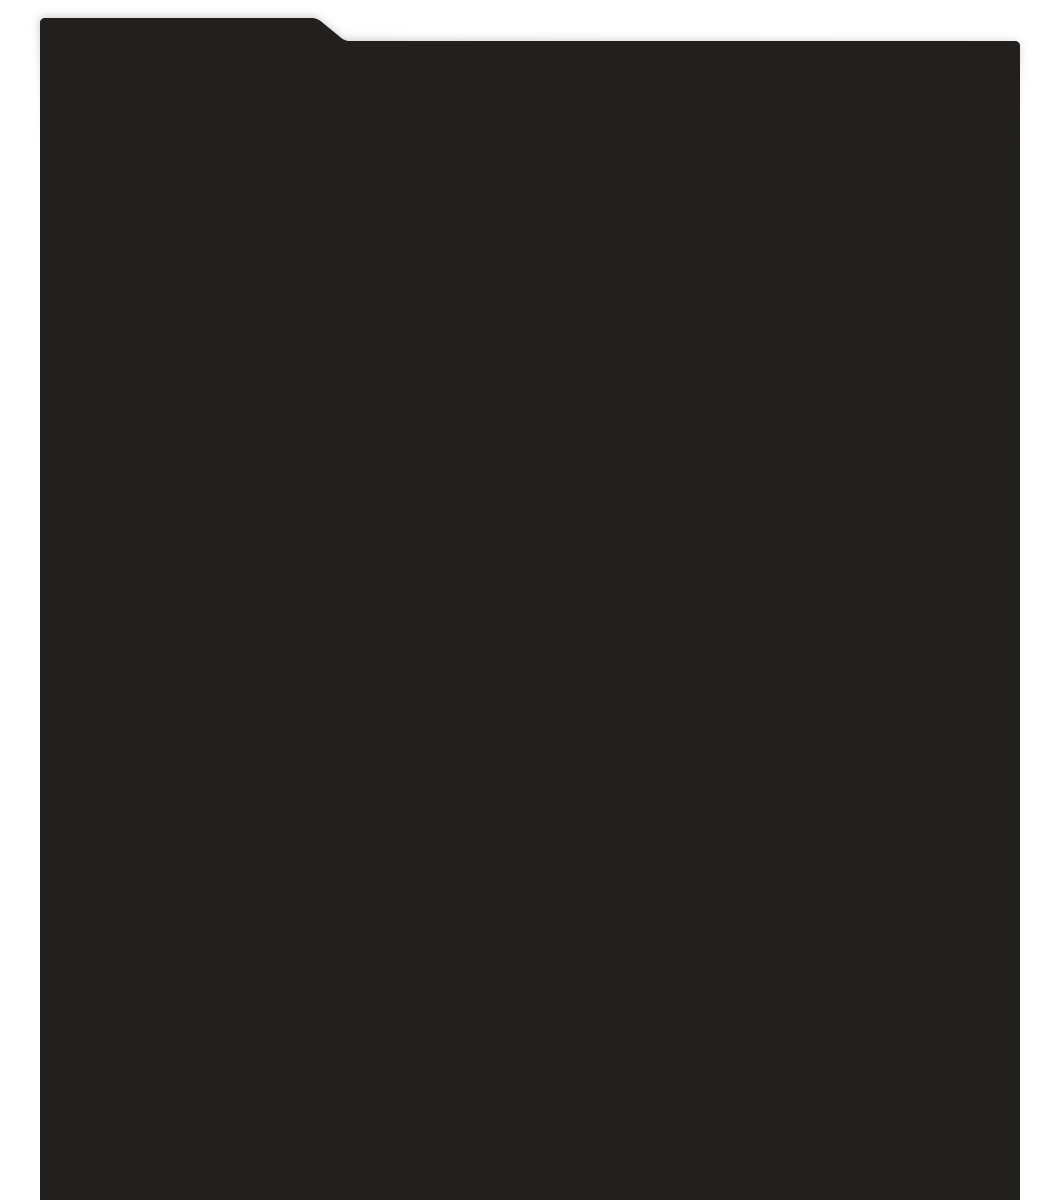
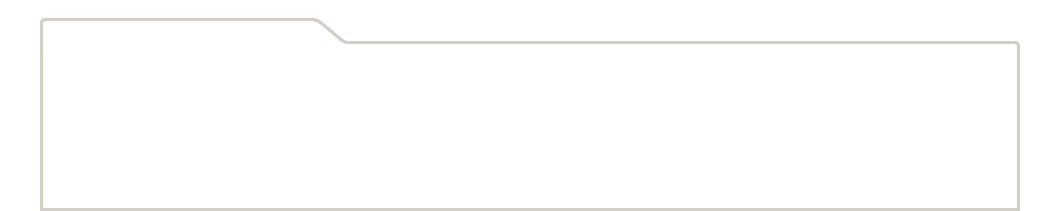
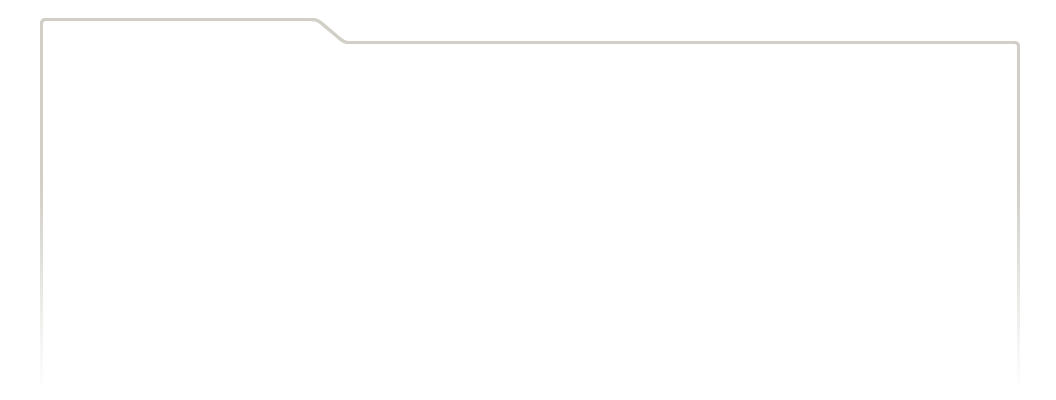
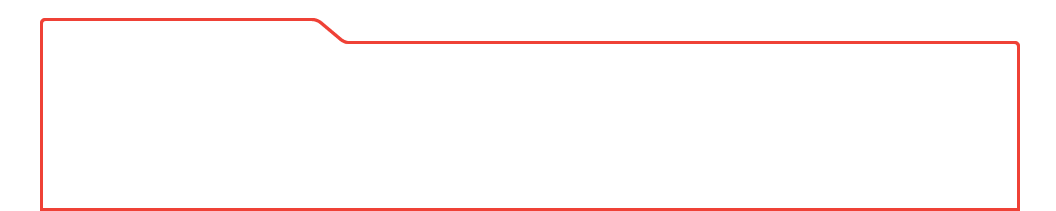
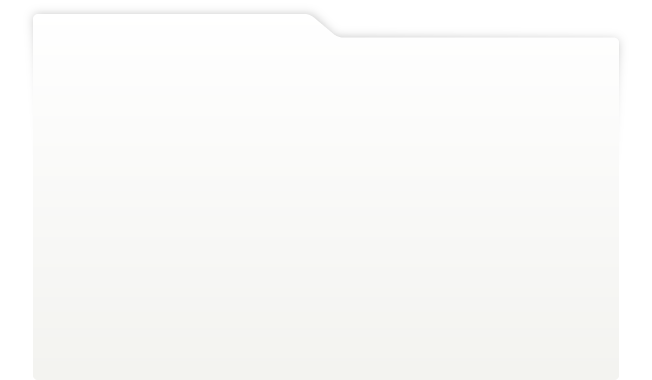
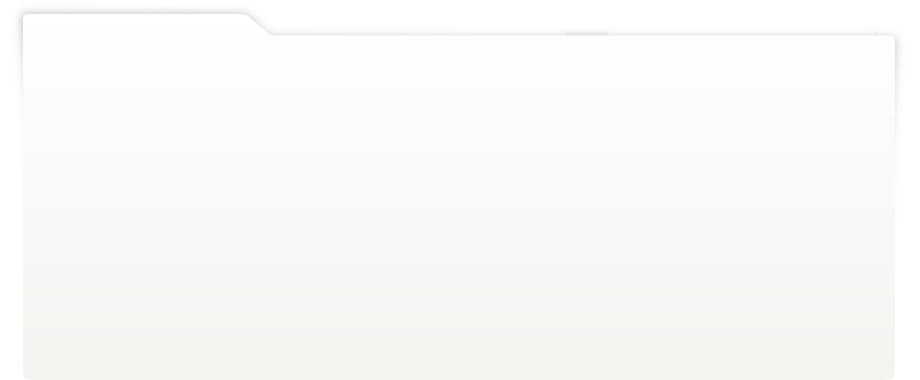
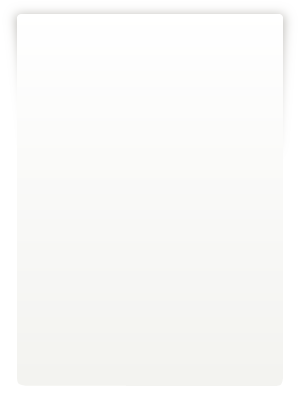
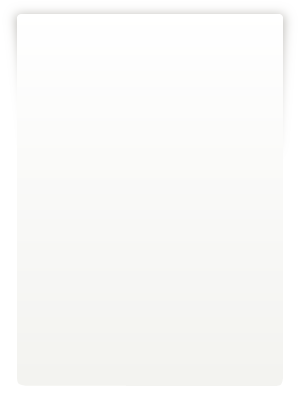
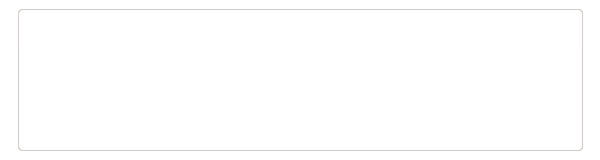
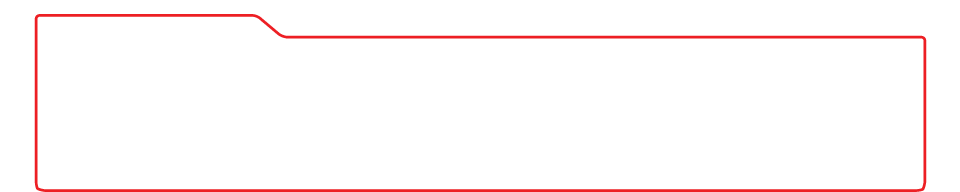
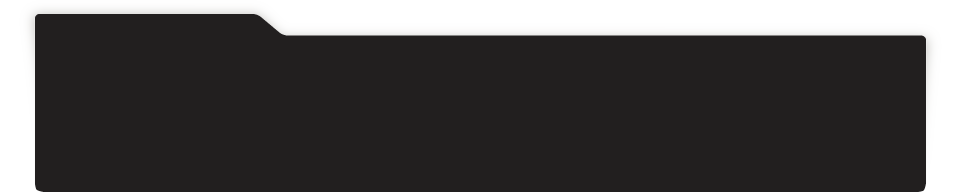
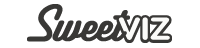
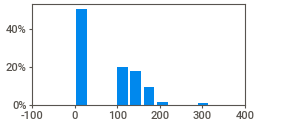
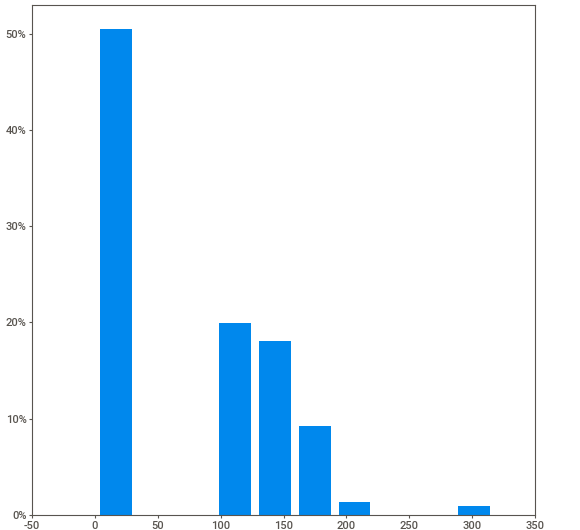
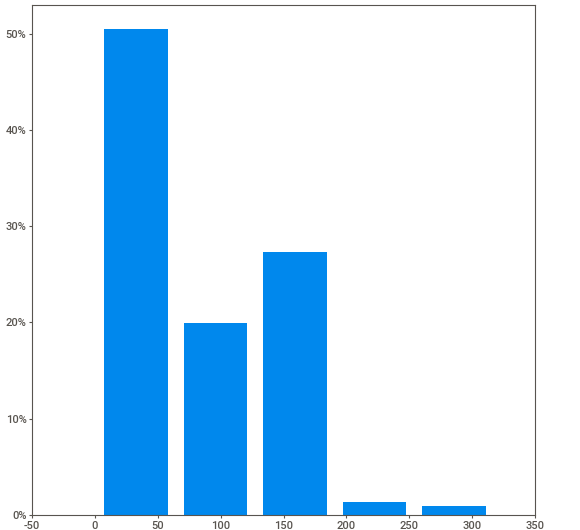
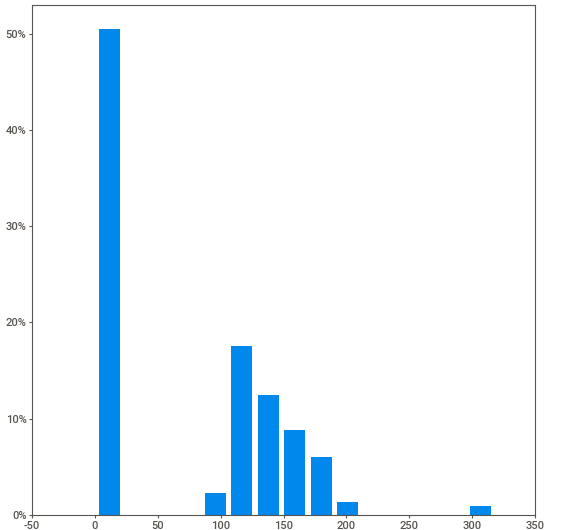
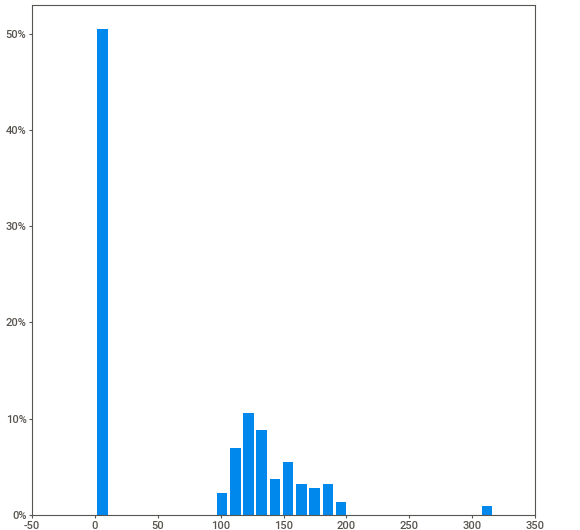
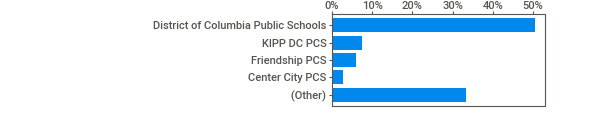
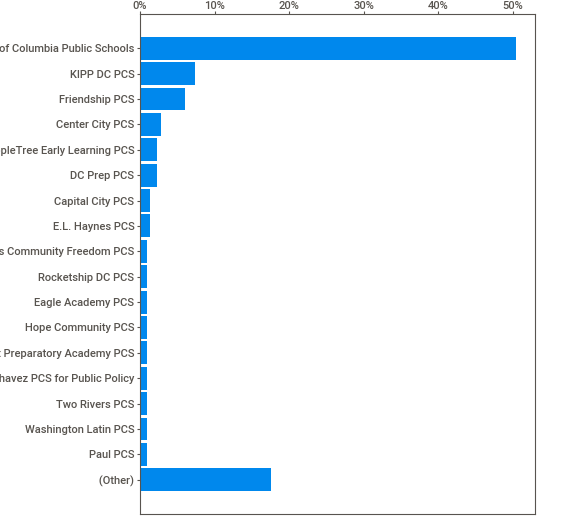
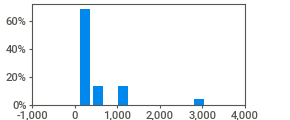
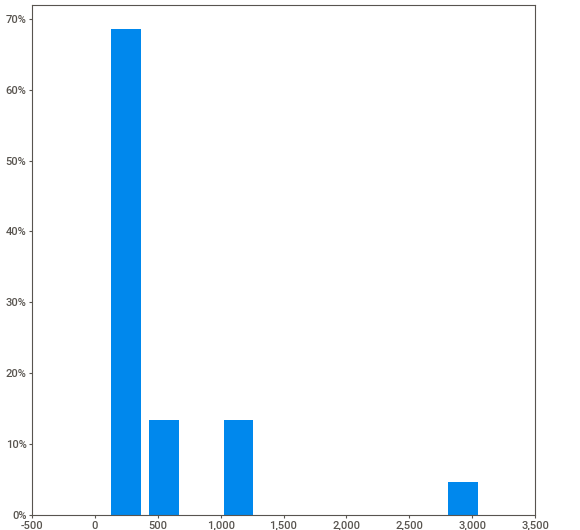
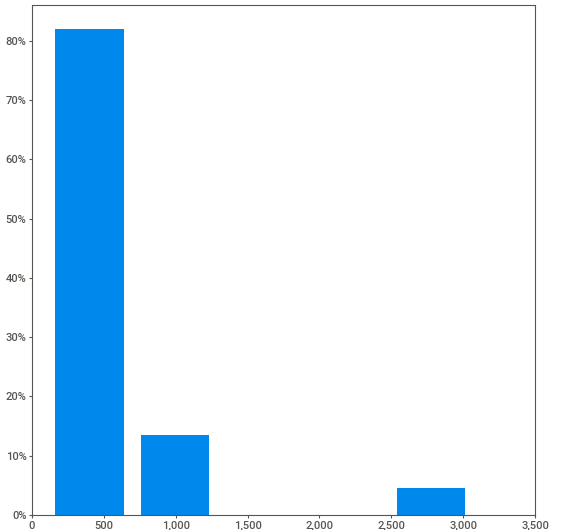
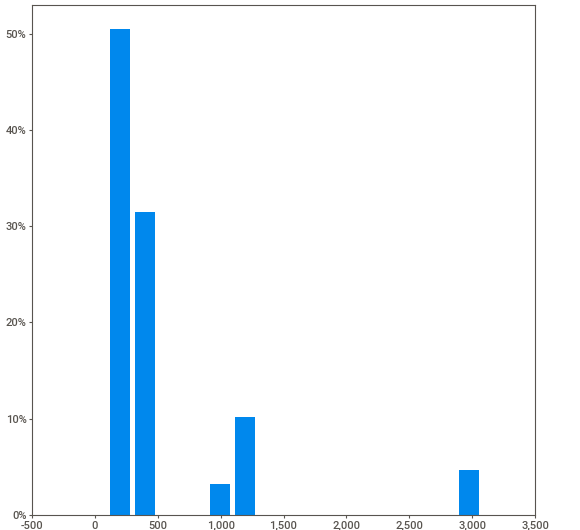
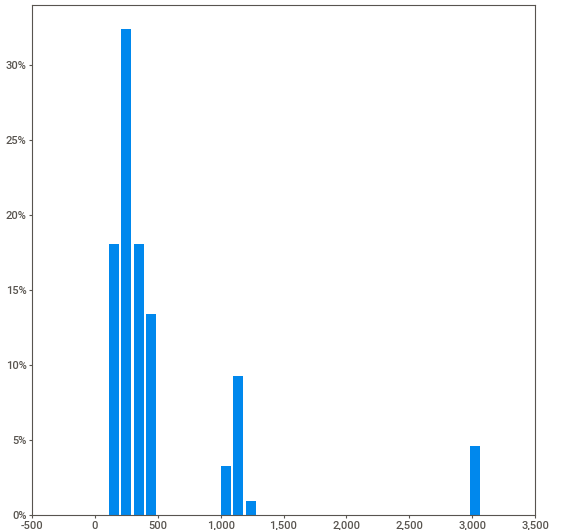
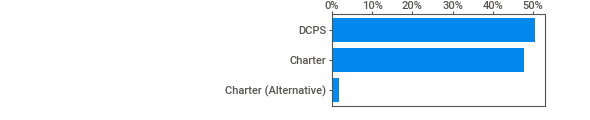
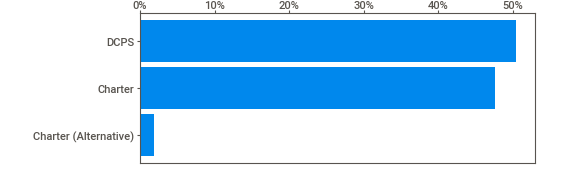
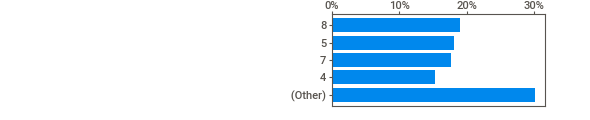
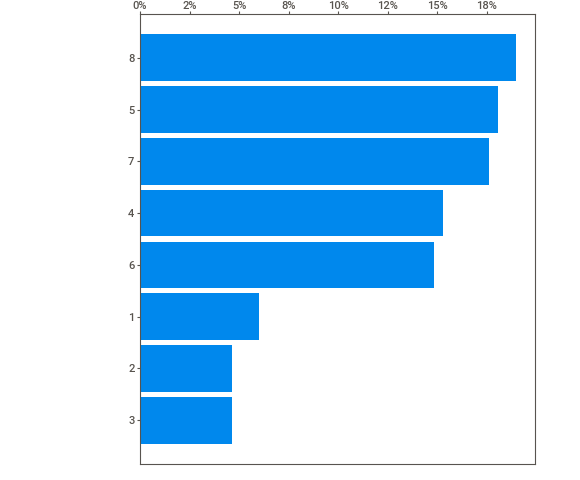
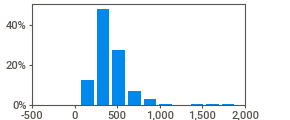
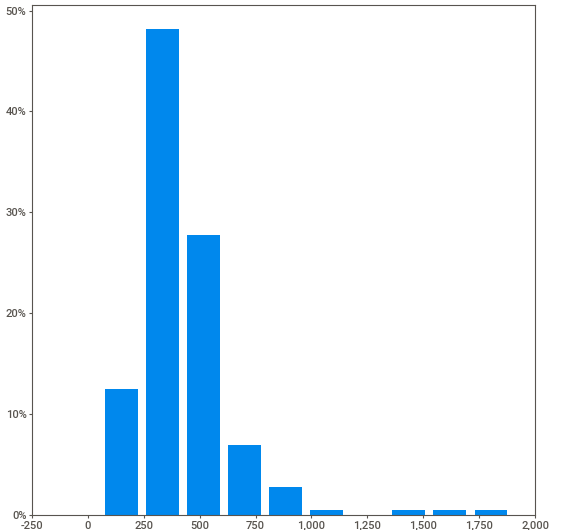
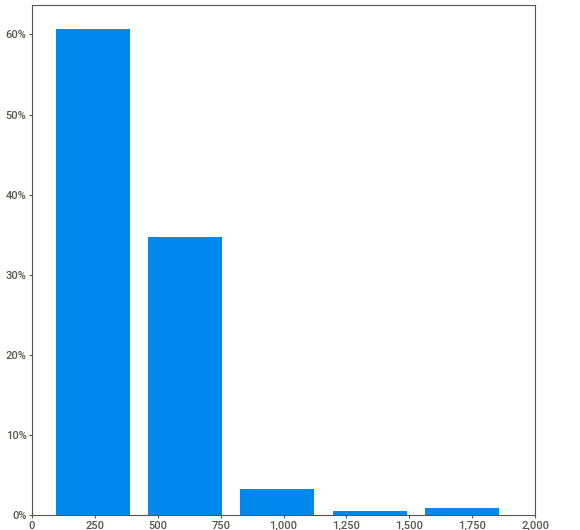
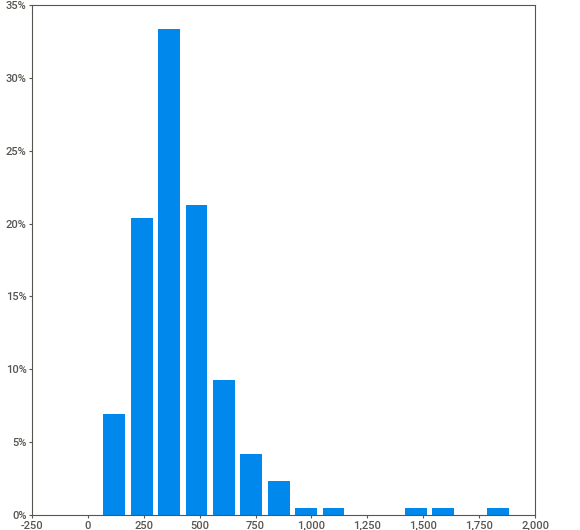
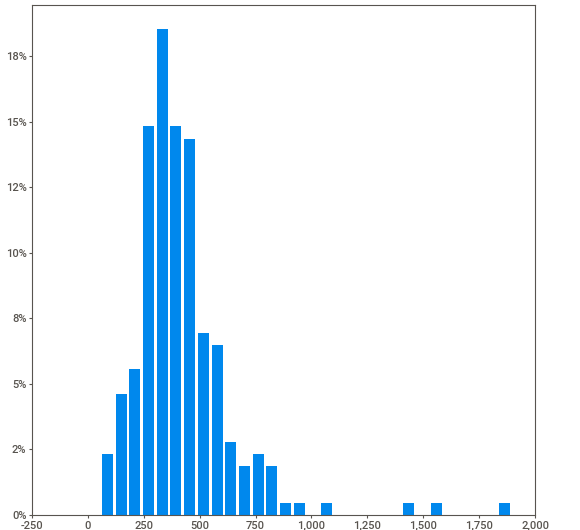
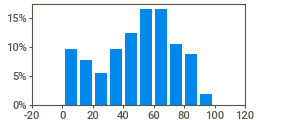
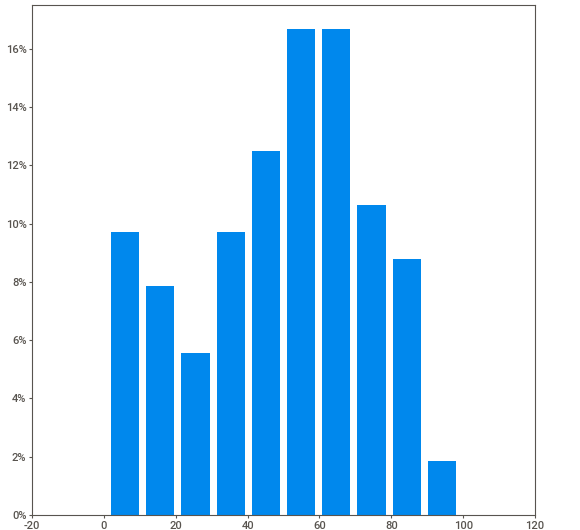
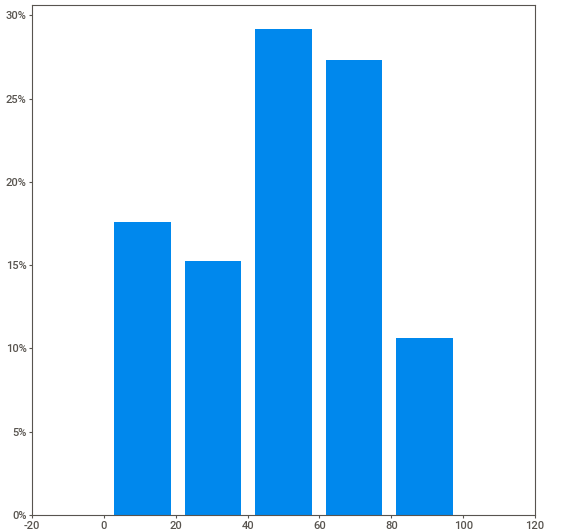
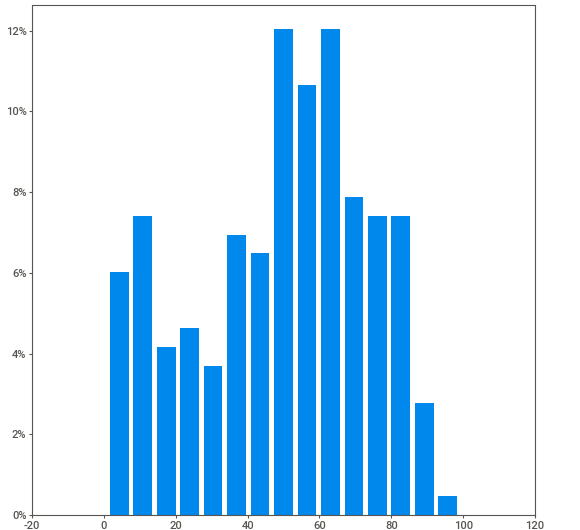
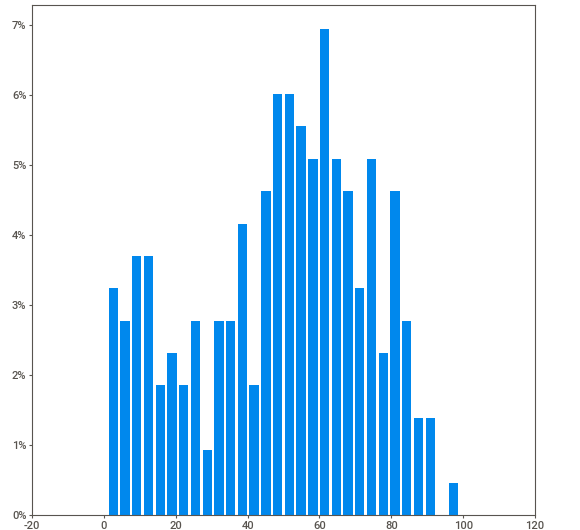
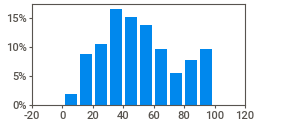
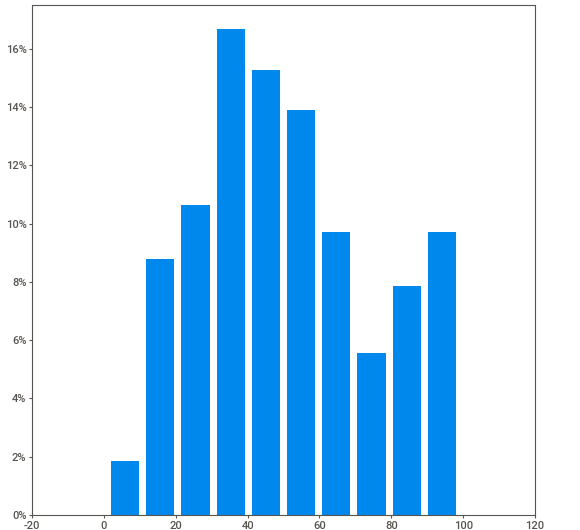
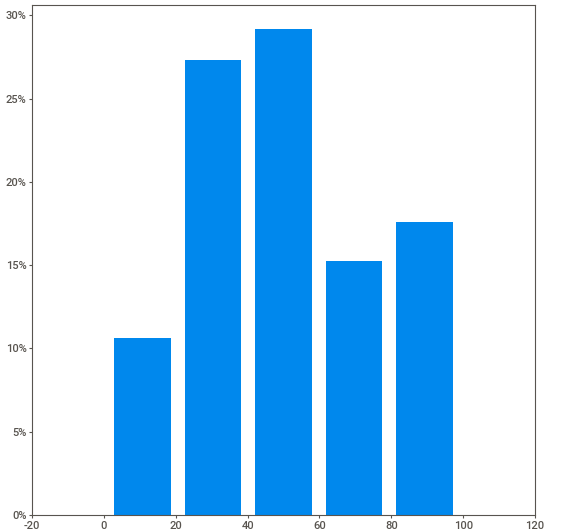
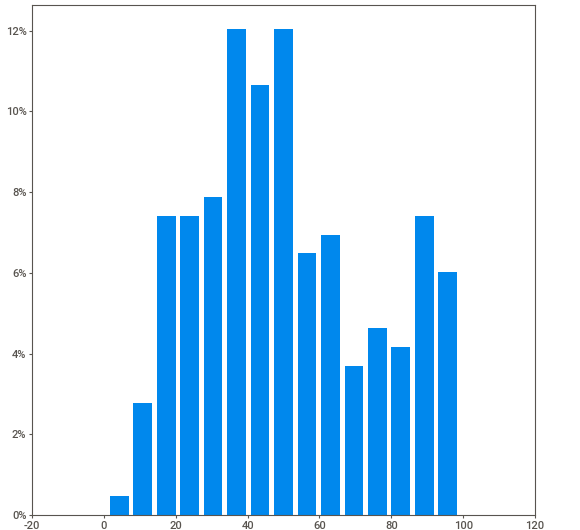
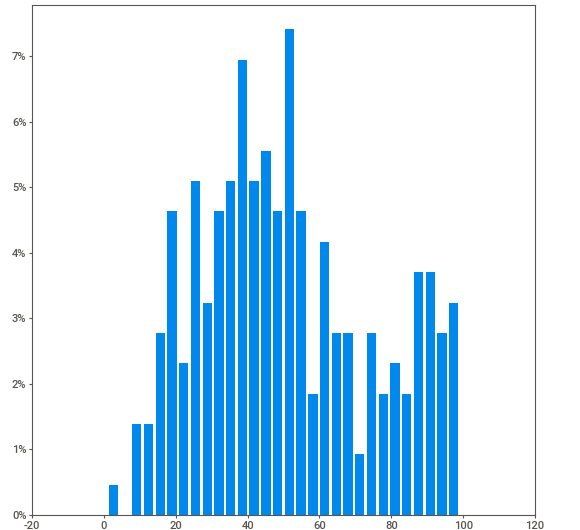
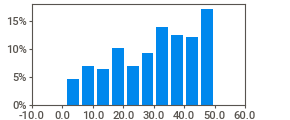
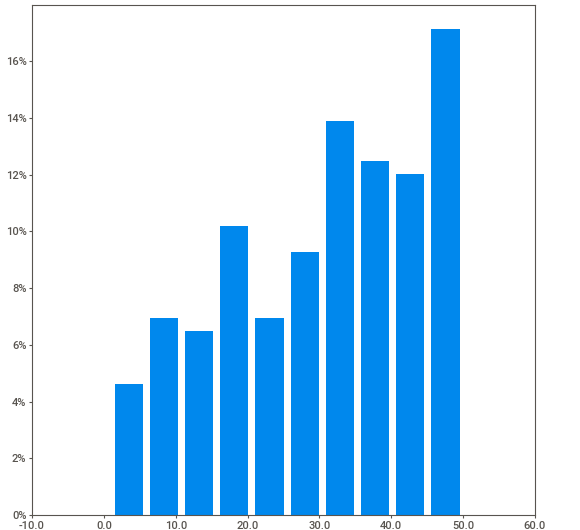
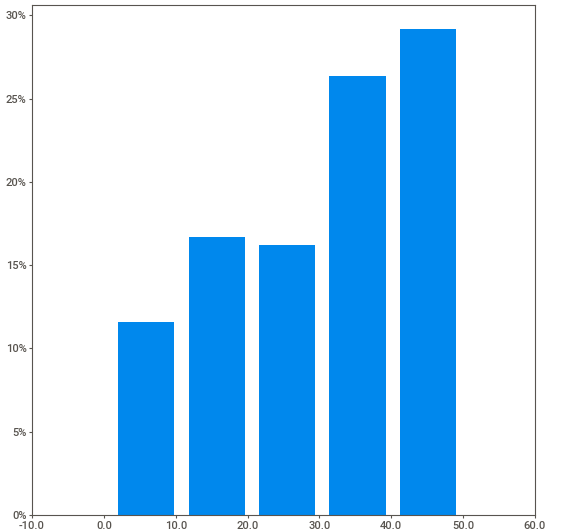
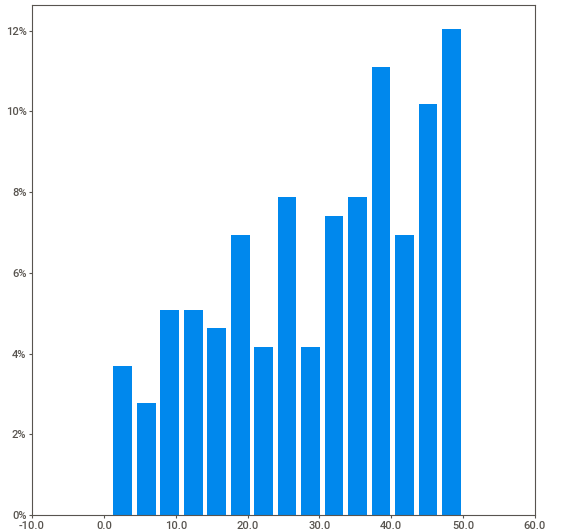
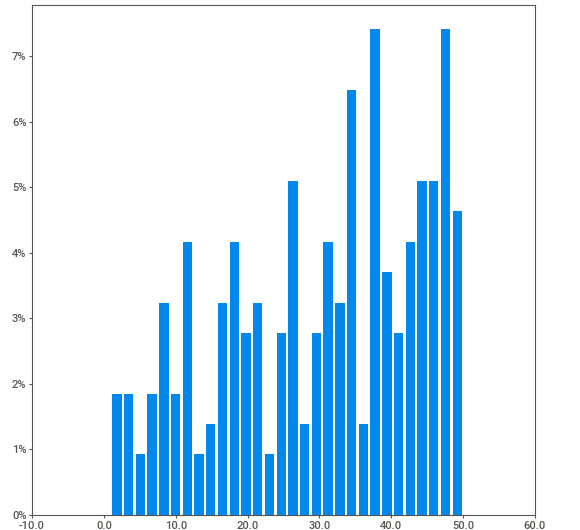
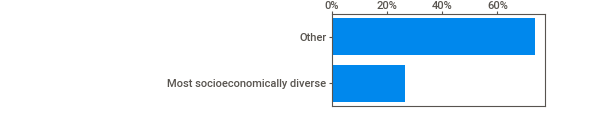
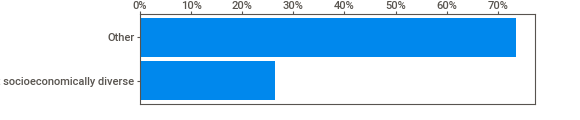
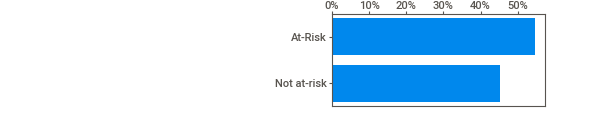
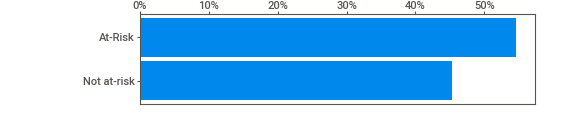
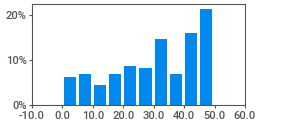
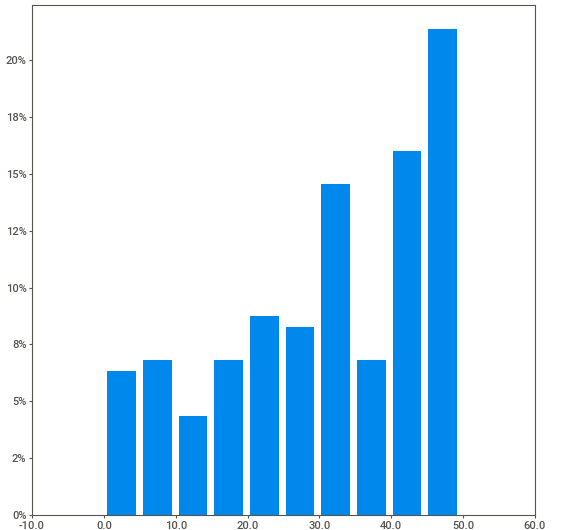
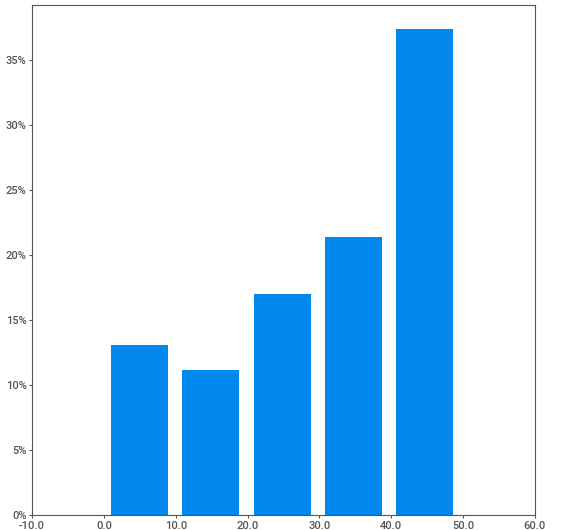
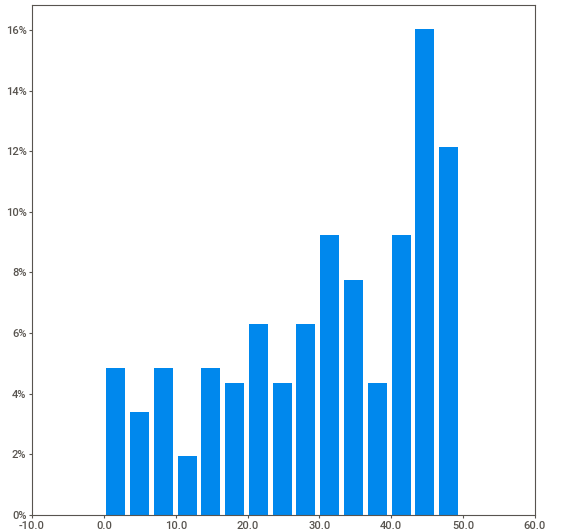
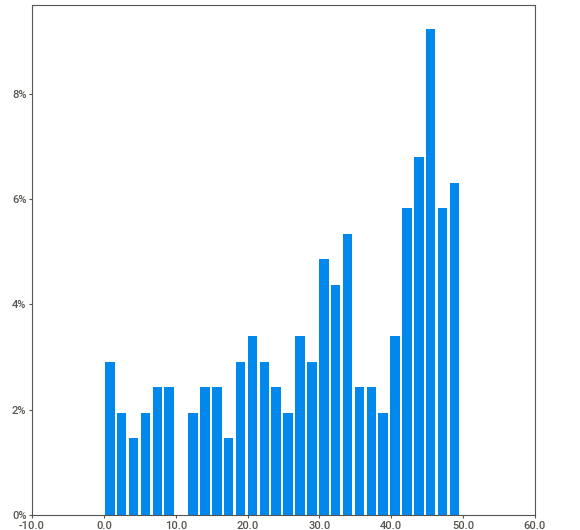
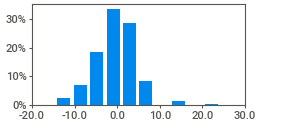
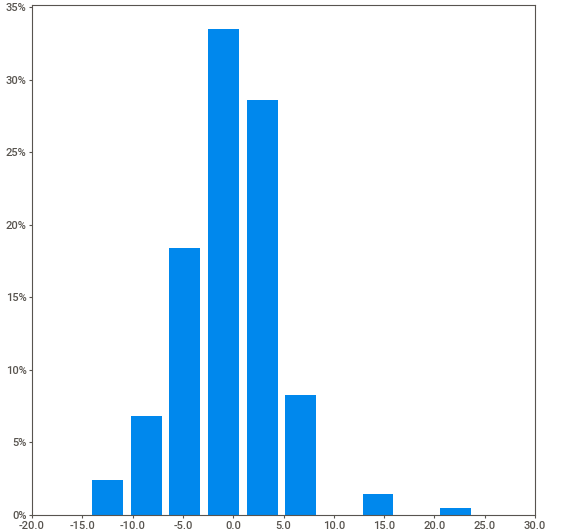
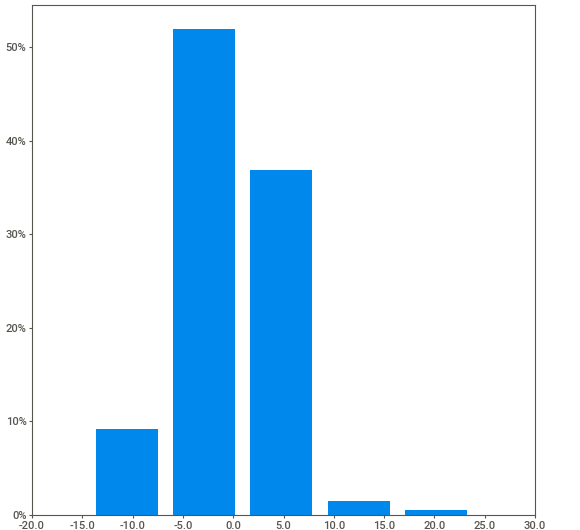
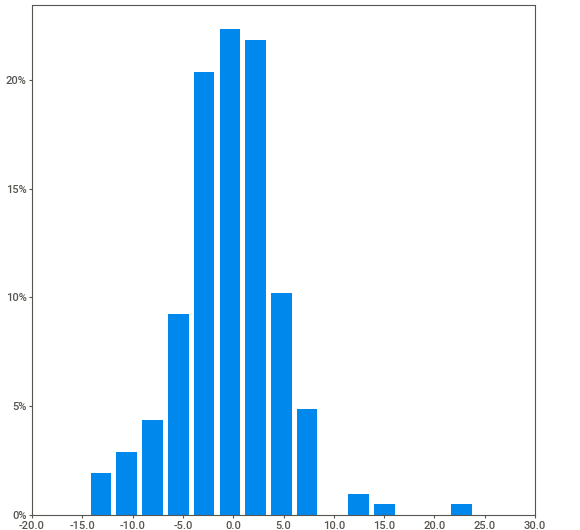
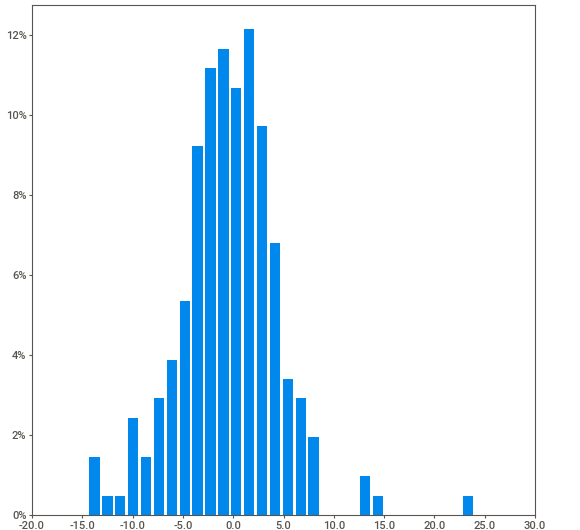
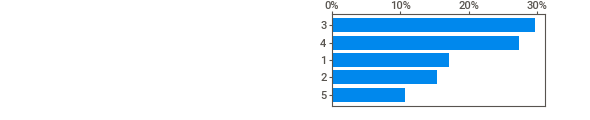
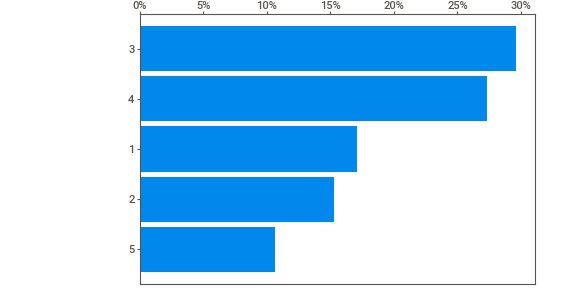
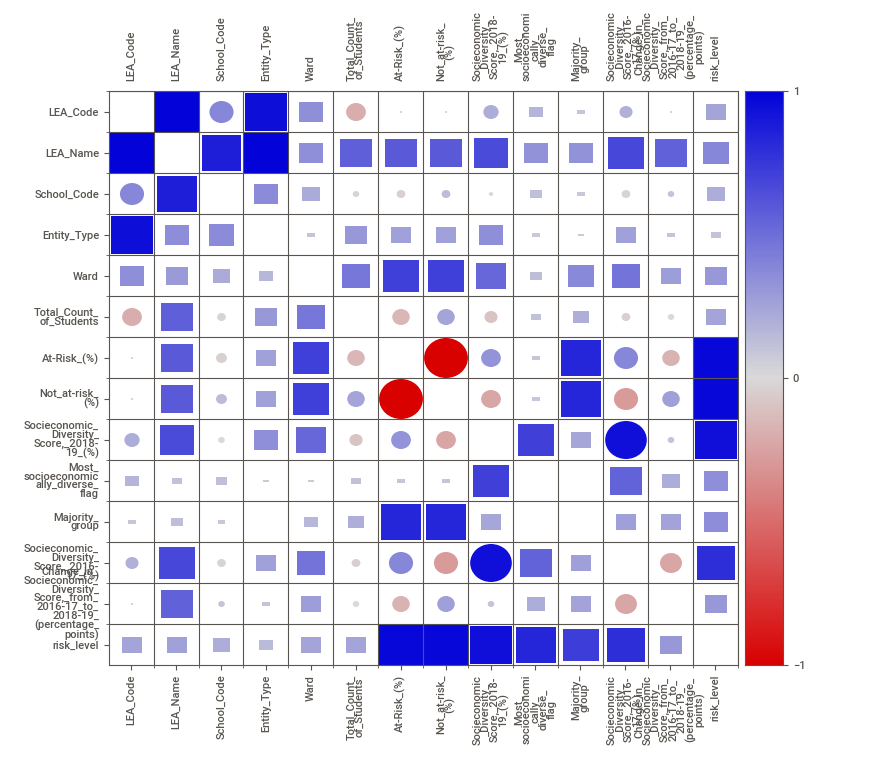
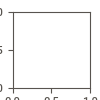

In [23]:
diversity_ana = sv.analyze(diversity)
diversity_ana.show_notebook()

# analyze the financial
## cmp nces(financial) data between years 
columns need to compare include:

pp_total_raw_DC, pp_site_raw_DC, pp_centshare_raw_DC, schoolstloc_raw_DC, enroll_raw_DC

In [24]:
nces.head()

,schoolid_stateassigned,schoolname,level,schtype_raw_DC,distid_stateassigned,distname,year_1819,pp_total_raw_DC_1819,pp_site_raw_DC_1819,pp_centshare_raw_DC_1819,schoolstloc_raw_DC_1819,enroll_raw_DC_1819,year_1920,pp_total_raw_DC_1920,pp_site_raw_DC_1920,pp_centshare_raw_DC_1920,schoolstloc_raw_DC_1920,enroll_raw_DC_1920
0,233,Academy of Hope Adult PCS,NaN,Charter,178,Academy of Hope Adult PCS,2018-2019,14478.0,NaN,NaN,6199570.0,463.0,2019-2020,14670.0,NaN,NaN,5566158.0,486.0
1,217,Achievement Preparatory Academy PCS - Wahler P...,2.0,Charter,155,Achievement Preparatory Academy PCS,2018-2019,22085.0,18270.0,3815.0,7525500.0,375.0,2019-2020,19357.0,8764.0,10593.0,6333696.0,384.0
2,1100,Achievement Preparatory Academy PCS - Wahler P...,3.0,Charter,155,Achievement Preparatory Academy PCS,2018-2019,17575.0,13403.0,4171.0,6951600.0,450.0,2019-2020,21630.0,10708.0,10922.0,6652869.0,361.0
3,140,AppleTree Early Learning Center PCS - Columbia...,1.0,Charter,103,AppleTree Early Learning PCS,2018-2019,20263.0,16917.0,3346.0,2864400.0,154.0,2019-2020,21271.0,17668.0,3603.0,2409036.0,147.0
4,3072,AppleTree Early Learning Center PCS - Douglas ...,1.0,Charter,103,AppleTree Early Learning PCS,2018-2019,19798.0,16453.0,3346.0,1566270.0,90.0,2019-2020,20762.0,17159.0,3603.0,1356805.0,89.0


In [25]:
def cmp_numeric_data(data, col):

    data[col+ '_inc(%)'] = data[[col+'_1819', col+'_1920']].pct_change(axis='columns', periods=-1)[col+'_1819']
    data[col+ '_inc'] = data[col+'_1819'] - data[col+'_1920']
    return data

In [26]:
cmp_columns = ['pp_total_raw_DC', 'pp_site_raw_DC', 'pp_centshare_raw_DC', 'schoolstloc_raw_DC', 'enroll_raw_DC']
for c in cmp_columns:
    nces = cmp_numeric_data(nces, c)
nces.columns

Index(['schoolid_stateassigned', 'schoolname', 'level', 'schtype_raw_DC',
       'distid_stateassigned', 'distname', 'year_1819', 'pp_total_raw_DC_1819',
       'pp_site_raw_DC_1819', 'pp_centshare_raw_DC_1819',
       'schoolstloc_raw_DC_1819', 'enroll_raw_DC_1819', 'year_1920',
       'pp_total_raw_DC_1920', 'pp_site_raw_DC_1920',
       'pp_centshare_raw_DC_1920', 'schoolstloc_raw_DC_1920',
       'enroll_raw_DC_1920', 'pp_total_raw_DC_inc(%)', 'pp_total_raw_DC_inc',
       'pp_site_raw_DC_inc(%)', 'pp_site_raw_DC_inc',
       'pp_centshare_raw_DC_inc(%)', 'pp_centshare_raw_DC_inc',
       'schoolstloc_raw_DC_inc(%)', 'schoolstloc_raw_DC_inc',
       'enroll_raw_DC_inc(%)', 'enroll_raw_DC_inc'],
      dtype='object')

In [27]:
nces[['pp_total_raw_DC_inc(%)', 'pp_total_raw_DC_inc',
       'pp_site_raw_DC_inc(%)', 'pp_site_raw_DC_inc',
       'pp_centshare_raw_DC_inc(%)', 'pp_centshare_raw_DC_inc',
       'schoolstloc_raw_DC_inc(%)', 'schoolstloc_raw_DC_inc',
       'enroll_raw_DC_inc(%)', 'enroll_raw_DC_inc']].head()

,pp_total_raw_DC_inc(%),pp_total_raw_DC_inc,pp_site_raw_DC_inc(%),pp_site_raw_DC_inc,pp_centshare_raw_DC_inc(%),pp_centshare_raw_DC_inc,schoolstloc_raw_DC_inc(%),schoolstloc_raw_DC_inc,enroll_raw_DC_inc(%),enroll_raw_DC_inc
0,-0.013088,-192.0,NaN,NaN,NaN,NaN,0.113797,633412.0,-0.047325,-23.0
1,0.140931,2728.0,1.084665,9506.0,-0.639857,-6778.0,0.188169,1191804.0,-0.023438,-9.0
2,-0.187471,-4055.0,0.251681,2695.0,-0.618110,-6751.0,0.044903,298731.0,0.246537,89.0
3,-0.047388,-1008.0,-0.042506,-751.0,-0.071329,-257.0,0.189023,455364.0,0.047619,7.0
4,-0.046431,-964.0,-0.041145,-706.0,-0.071329,-257.0,0.154381,209465.0,0.011236,1.0


In [28]:
nces.to_csv("../Dataset/final_data/nces.csv")

# final merge all data

In [66]:
print(star.columns)
print(nces.columns)
print(diversity.columns)

Index(['School_Code', 'STAR_Score_18', 'STAR_Rating_18', 'STAR_Score_19',
       'STAR_Rating_19'],
      dtype='object')
Index(['schoolid_stateassigned', 'schoolname', 'level', 'schtype_raw_DC',
       'distid_stateassigned', 'distname', 'year_1819', 'pp_total_raw_DC_1819',
       'pp_site_raw_DC_1819', 'pp_centshare_raw_DC_1819',
       'schoolstloc_raw_DC_1819', 'enroll_raw_DC_1819', 'year_1920',
       'pp_total_raw_DC_1920', 'pp_site_raw_DC_1920',
       'pp_centshare_raw_DC_1920', 'schoolstloc_raw_DC_1920',
       'enroll_raw_DC_1920', 'pp_total_raw_DC_inc(%)', 'pp_total_raw_DC_inc',
       'pp_site_raw_DC_inc(%)', 'pp_site_raw_DC_inc',
       'pp_centshare_raw_DC_inc(%)', 'pp_centshare_raw_DC_inc',
       'schoolstloc_raw_DC_inc(%)', 'schoolstloc_raw_DC_inc',
       'enroll_raw_DC_inc(%)', 'enroll_raw_DC_inc'],
      dtype='object')
Index(['LEA_Code', 'LEA_Name', 'School_Code', 'School_Name', 'Entity_Type',
       'Ward', 'Total_Count_of_Students', 'At-Risk_(%)', 'Not_at-risk_(%

In [67]:
all_df = star.merge(nces, left_on='School_Code', right_on='schoolid_stateassigned')
all_df = all_df.merge(diversity.add_prefix('diversity_'), left_on='School_Code', right_on='diversity_School_Code')

[[i, j] for i,j in combinations(all_df, 2) if all_df[i].equals(all_df[j])]

[['School_Code', 'schoolid_stateassigned'],
 ['School_Code', 'diversity_School_Code'],
 ['schoolid_stateassigned', 'diversity_School_Code'],
 ['schtype_raw_DC', 'diversity_Entity_Type'],
 ['distid_stateassigned', 'diversity_LEA_Code']]

In [68]:
final_drop_cols = ['schoolid_stateassigned', 'diversity_School_Code', 'diversity_Entity_Type', 'diversity_LEA_Code', \
                   'diversity_Not_at-risk_(%)', 'year_1819', 'year_1920', 'diversity_LEA_Name', 'diversity_School_Name',\
                   'diversity_Most_socioeconomically_diverse_flag', 'diversity_Majority_group']
all_df = all_df.drop(final_drop_cols, axis=1)
all_df.rename(columns = {'distid_stateassigned':'Dist_Code', 
                         'diversity_Total_Count_of_Students': 'Total_Count_of_Students', 
                         'diversity_Ward': 'Ward'}, inplace = True)
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191 entries, 0 to 190
Data columns (total 37 columns):
 #   Column                                                                                         Non-Null Count  Dtype   
---  ------                                                                                         --------------  -----   
 0   School_Code                                                                                    191 non-null    int64   
 1   STAR_Score_18                                                                                  191 non-null    float64 
 2   STAR_Rating_18                                                                                 191 non-null    int64   
 3   STAR_Score_19                                                                                  191 non-null    float64 
 4   STAR_Rating_19                                                                                 191 non-null    int64   
 5   schoolname     

In [71]:
all_df['STAR_Score_inc'] = all_df.STAR_Score_18 - all_df.STAR_Score_19
all_df['STAR_Score_inc(%)'] = all_df[['STAR_Score_18', 'STAR_Score_19']].pct_change(axis='columns', periods=-1)['STAR_Score_18']
all_df['STAR_Score_inc'] = all_df.STAR_Rating_18 - all_df.STAR_Rating_19
all_df['STAR_Rating_inc(%)'] = all_df[['STAR_Rating_18', 'STAR_Rating_19']].pct_change(axis='columns', periods=-1)['STAR_Rating_18']

In [72]:
all_df.columns

Index(['School_Code', 'STAR_Score_18', 'STAR_Rating_18', 'STAR_Score_19',
       'STAR_Rating_19', 'schoolname', 'level', 'schtype_raw_DC', 'Dist_Code',
       'distname', 'pp_total_raw_DC_1819', 'pp_site_raw_DC_1819',
       'pp_centshare_raw_DC_1819', 'schoolstloc_raw_DC_1819',
       'enroll_raw_DC_1819', 'pp_total_raw_DC_1920', 'pp_site_raw_DC_1920',
       'pp_centshare_raw_DC_1920', 'schoolstloc_raw_DC_1920',
       'enroll_raw_DC_1920', 'pp_total_raw_DC_inc(%)', 'pp_total_raw_DC_inc',
       'pp_site_raw_DC_inc(%)', 'pp_site_raw_DC_inc',
       'pp_centshare_raw_DC_inc(%)', 'pp_centshare_raw_DC_inc',
       'schoolstloc_raw_DC_inc(%)', 'schoolstloc_raw_DC_inc',
       'enroll_raw_DC_inc(%)', 'enroll_raw_DC_inc', 'Ward',
       'Total_Count_of_Students', 'diversity_At-Risk_(%)',
       'diversity_Socieconomic_Diversity_Score,_2018-19_(%)',
       'diversity_Socieconomic_Diversity_Score,_2016-17_(%)',
       'diversity_Change_in_Socieconomic_Diversity_Score,_from_2016-17_to_2018-1

In [73]:
all_df.to_csv("../Dataset/final_data/final_data.csv")

# analyze dataset

In [35]:
from plotnine import *

In [117]:
all_df.diversity_risk_level.dtype

CategoricalDtype(categories=[1, 2, 3, 4, 5], ordered=True)

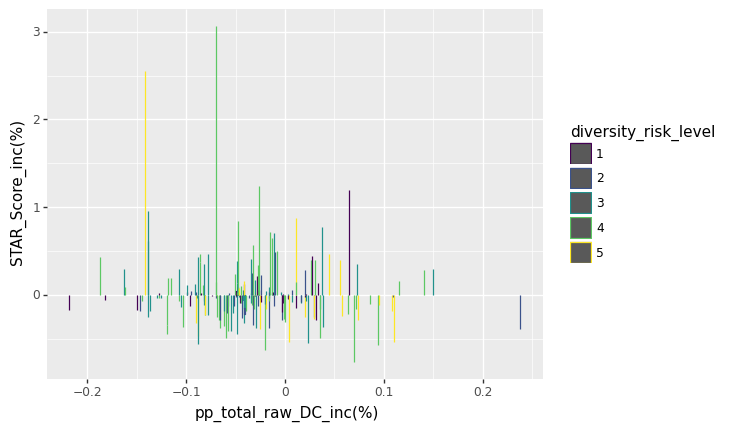

<ggplot: (8749994547389)>

In [125]:
(ggplot( all_df, aes(x='pp_total_raw_DC_inc(%)', y='STAR_Score_inc(%)', color='diversity_risk_level')) +
    geom_col())

In [74]:
wards_data = pd.DataFrame()

wards_data['pp_total_raw'] = all_df.groupby('Ward')['pp_total_raw_DC_inc(%)'].agg("mean")
wards_data['enroll_raw_DC_inc'] = all_df.groupby('Ward')['enroll_raw_DC_inc(%)'].agg("mean")
wards_data['STAR_Score'] = all_df.groupby('Ward')['STAR_Score_inc(%)'].agg("mean")
wards_data['STAR_Rating'] = all_df.groupby('Ward')['STAR_Rating_inc(%)'].agg("mean")
wards_data['Ward'] = wards_data.index

In [115]:
Dist_data = pd.DataFrame()

Dist_data['pp_total_raw_inc'] = all_df.groupby('distname')['pp_total_raw_DC_inc(%)'].agg("mean")
Dist_data['pp_total_raw_1920'] = all_df.groupby('distname')['pp_total_raw_DC_1920'].agg("mean")
Dist_data['Risk(%)'] = all_df.groupby('distname')['diversity_At-Risk_(%)'].agg("mean")
Dist_data['pp_centshare_raw'] = all_df.groupby('distname')['pp_centshare_raw_DC_inc(%)'].agg("mean")
Dist_data['schoolstloc_raw'] = all_df.groupby('distname')['schoolstloc_raw_DC_inc(%)'].agg("mean")
Dist_data['enroll_raw_DC_inc'] = all_df.groupby('distname')['enroll_raw_DC_inc(%)'].agg("mean")
Dist_data['STAR_Score_inc'] = all_df.groupby('distname')['STAR_Score_inc(%)'].agg("mean")
Dist_data['STAR_Score_19'] = all_df.groupby('distname')['STAR_Score_19'].agg("mean")
Dist_data['STAR_Rating'] = all_df.groupby('distname')['STAR_Rating_inc(%)'].agg("mean")
Dist_data['distname'] = Dist_data.index

In [152]:
all_df.columns

Index(['School_Code', 'STAR_Score_18', 'STAR_Rating_18', 'STAR_Score_19',
       'STAR_Rating_19', 'schoolname', 'level', 'schtype_raw_DC', 'Dist_Code',
       'distname', 'pp_total_raw_DC_1819', 'pp_site_raw_DC_1819',
       'pp_centshare_raw_DC_1819', 'schoolstloc_raw_DC_1819',
       'enroll_raw_DC_1819', 'pp_total_raw_DC_1920', 'pp_site_raw_DC_1920',
       'pp_centshare_raw_DC_1920', 'schoolstloc_raw_DC_1920',
       'enroll_raw_DC_1920', 'pp_total_raw_DC_inc(%)', 'pp_total_raw_DC_inc',
       'pp_site_raw_DC_inc(%)', 'pp_site_raw_DC_inc',
       'pp_centshare_raw_DC_inc(%)', 'pp_centshare_raw_DC_inc',
       'schoolstloc_raw_DC_inc(%)', 'schoolstloc_raw_DC_inc',
       'enroll_raw_DC_inc(%)', 'enroll_raw_DC_inc', 'Ward',
       'Total_Count_of_Students', 'diversity_At-Risk_(%)',
       'diversity_Socieconomic_Diversity_Score,_2018-19_(%)',
       'diversity_Socieconomic_Diversity_Score,_2016-17_(%)',
       'diversity_Change_in_Socieconomic_Diversity_Score,_from_2016-17_to_2018-1

/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


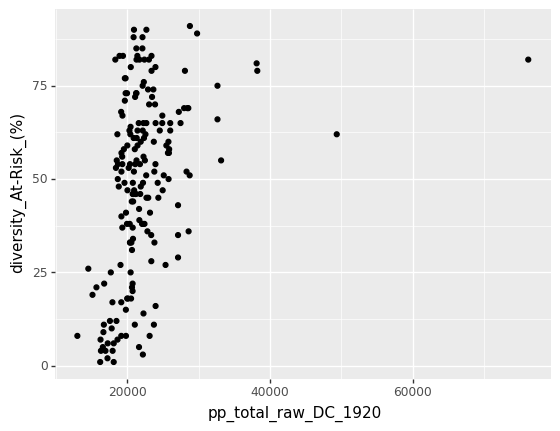

<ggplot: (8749994981093)>

In [155]:
ggplot(all_df, aes(x='pp_total_raw_DC_1920', y='diversity_At-Risk_(%)')) + geom_point()

/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


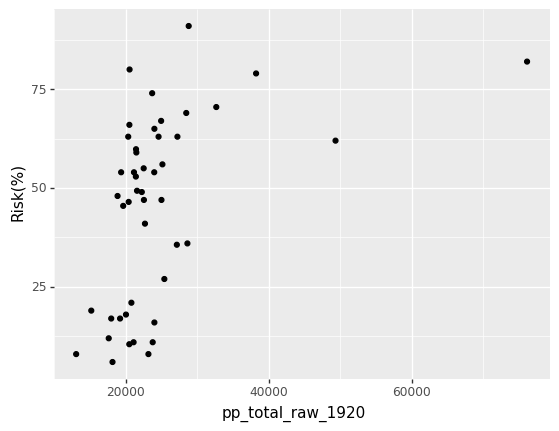

<ggplot: (8749994516585)>

In [116]:
ggplot(Dist_data, aes(x='pp_total_raw_1920', y='Risk(%)')) + geom_point()

In [ ]:
(ggplot(Dist_data) 
    + geom_bar( aes(x ='reorder(distname, STAR_Score)', y = 'STAR_Score'),stat='identity', fill = "blue", width = 0.2) 
    + geom_bar(aes(x ='reorder(distname, STAR_Score)', y = 'pp_total_raw'), 
               stat='identity', alpha = 0.3, fill = "red", width = 0.6 )
    + labs(title = 'the increase precentage of STAR_Score and per-pupil expenditure', x='District Name', y = "STAR_Score") 
    +coord_flip())

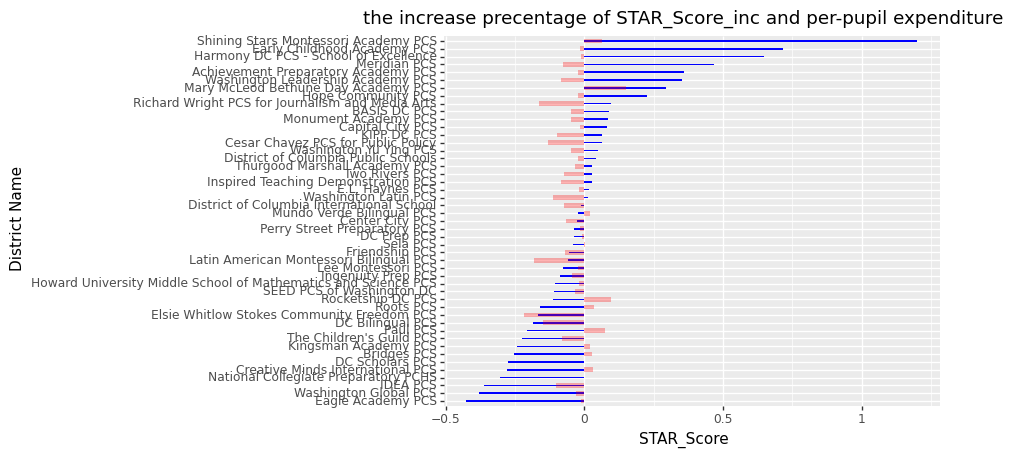

<ggplot: (8749995329305)>

In [159]:
(ggplot(Dist_data) 
    + geom_bar( aes(x ='reorder(distname, STAR_Score_inc)', y = 'STAR_Score_inc'),stat='identity', fill = "blue", width = 0.2) 
    + geom_bar(aes(x ='reorder(distname, STAR_Score_inc)', y = 'pp_total_raw_inc'), 
               stat='identity', alpha = 0.3, fill = "red", width = 0.6 )
    + labs(title = 'the increase precentage of STAR_Score_inc and per-pupil expenditure', x='District Name', y = "STAR_Score") 
    +coord_flip())

In [168]:
plotnine.options.figure_size = (12, 9)
plot = (ggplot(Dist_data) 
    + geom_bar( aes(x ='reorder(distname, STAR_Score_inc)', y = 'STAR_Score_inc'),stat='identity', fill = "blue", width = 0.2) 
    + geom_bar(aes(x ='reorder(distname, STAR_Score_inc)', y = 'pp_total_raw_inc'), 
               stat='identity', alpha = 0.3, fill = "red", width = 0.6 )
    + labs(title = 'the increase precentage of STAR_Score_inc and per-pupil expenditure', x='District Name', y = "STAR_Score")
    + theme(axis_text_x=element_text(size=5))
    + coord_flip())
plot.save('analyze.png', dpi=300)

/usr/local/lib/python3.7/dist-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 12 x 9 in image.
/usr/local/lib/python3.7/dist-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: analyze.png


In [163]:
plot = (ggplot(Dist_data) 
    + geom_bar( aes(x ='reorder(distname, STAR_Score_inc)', y = 'STAR_Score_inc'),stat='identity', fill = "blue", width = 0.2) 
    + geom_bar(aes(x ='reorder(distname, STAR_Score_inc)', y = 'pp_total_raw_inc'), 
               stat='identity', alpha = 0.3, fill = "red", width = 0.6 )
    + labs(title = 'the increase precentage of STAR_Score_inc and per-pupil expenditure', x='District Name', y = "STAR_Score")
    + theme(axis_text_x=element_text(size=10))
    + coord_flip())
plot.save('image.png', dpi=300)

/usr/local/lib/python3.7/dist-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/lib/python3.7/dist-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: image.png


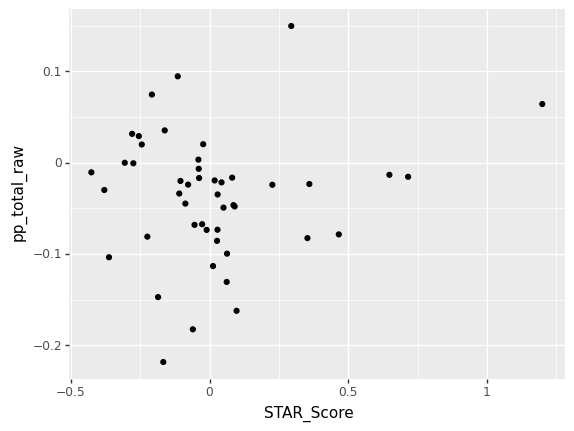

<ggplot: (8750012385053)>

In [92]:
ggplot(Dist_data, aes(x='STAR_Score', y='pp_total_raw')) + geom_point()

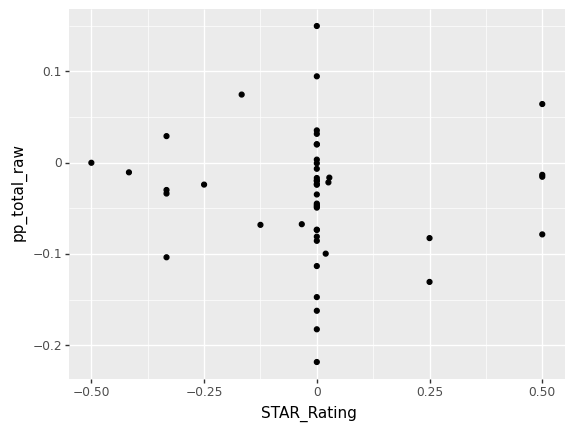

<ggplot: (8750012067481)>

In [94]:
ggplot(Dist_data, aes(x='STAR_Rating', y='pp_total_raw')) + geom_point()

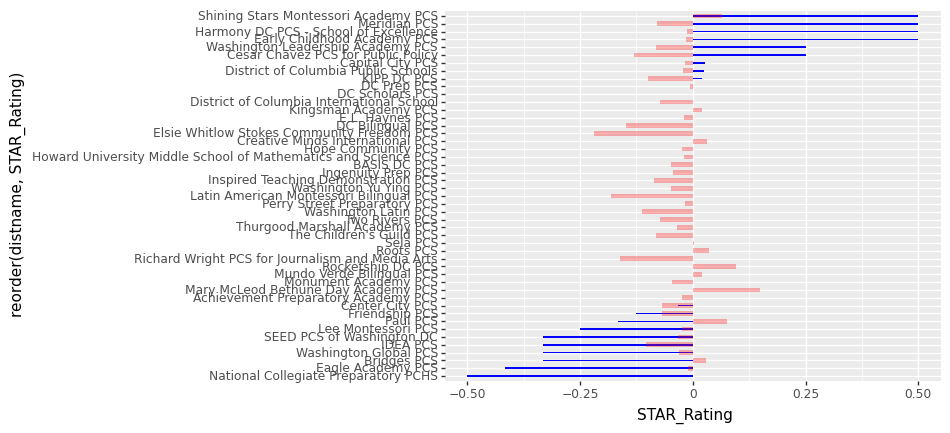

<ggplot: (8750012659209)>

In [93]:
(ggplot(Dist_data) 
    + geom_bar( aes(x ='reorder(distname, STAR_Rating)', y = 'STAR_Rating'),stat='identity', fill = "blue", width = 0.2) 
    + geom_bar(aes(x ='reorder(distname, STAR_Rating)', y = 'pp_total_raw'), 
               stat='identity', alpha = 0.3, fill = "red", width = 0.6 )
    +coord_flip())

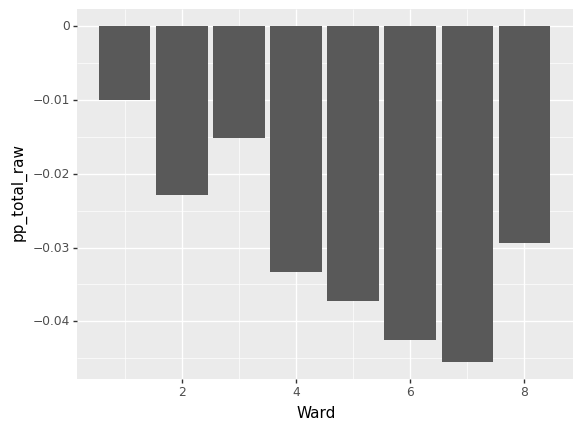

<ggplot: (8749995650021)>

In [77]:
(ggplot(wards_data) +
    geom_bar(aes(x ='Ward', y = 'pp_total_raw'), stat='identity') )

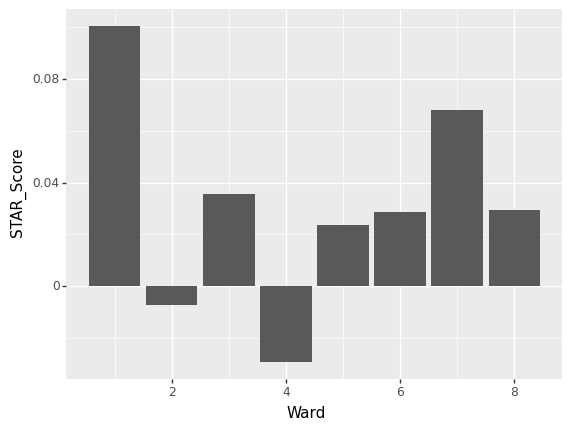

<ggplot: (8750009394285)>

In [78]:
(ggplot(wards_data) +
    geom_bar( aes(x ='Ward', y = 'STAR_Score'),stat='identity') )

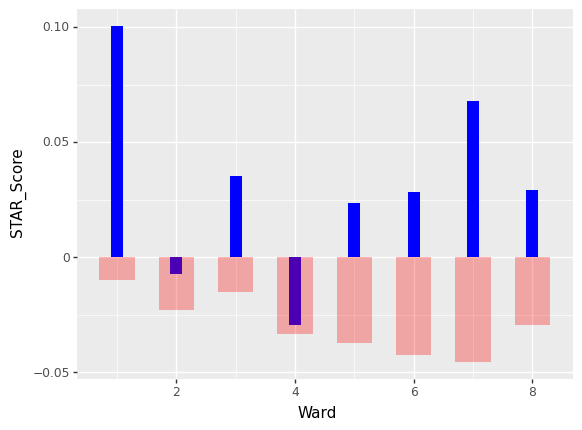

<ggplot: (8750012472841)>

In [81]:
(ggplot(wards_data) 
    + geom_bar( aes(x ='Ward', y = 'STAR_Score'),stat='identity', fill = "blue", width = 0.2) 
    + geom_bar(aes(x ='Ward', y = 'pp_total_raw'), stat='identity', alpha = 0.3, fill = "red", width = 0.6 ))

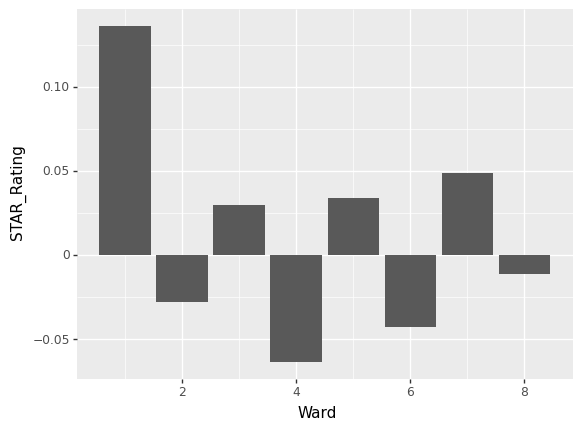

<ggplot: (8749995678397)>

In [76]:
(ggplot(wards_data, aes(x ='Ward', y = 'STAR_Rating')) +
    geom_bar(stat='identity') )

## correlation regression

In [131]:
from statsmodels.compat import lzip
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [130]:
all_df.columns

Index(['School_Code', 'STAR_Score_18', 'STAR_Rating_18', 'STAR_Score_19',
       'STAR_Rating_19', 'schoolname', 'level', 'schtype_raw_DC', 'Dist_Code',
       'distname', 'pp_total_raw_DC_1819', 'pp_site_raw_DC_1819',
       'pp_centshare_raw_DC_1819', 'schoolstloc_raw_DC_1819',
       'enroll_raw_DC_1819', 'pp_total_raw_DC_1920', 'pp_site_raw_DC_1920',
       'pp_centshare_raw_DC_1920', 'schoolstloc_raw_DC_1920',
       'enroll_raw_DC_1920', 'pp_total_raw_DC_inc(%)', 'pp_total_raw_DC_inc',
       'pp_site_raw_DC_inc(%)', 'pp_site_raw_DC_inc',
       'pp_centshare_raw_DC_inc(%)', 'pp_centshare_raw_DC_inc',
       'schoolstloc_raw_DC_inc(%)', 'schoolstloc_raw_DC_inc',
       'enroll_raw_DC_inc(%)', 'enroll_raw_DC_inc', 'Ward',
       'Total_Count_of_Students', 'diversity_At-Risk_(%)',
       'diversity_Socieconomic_Diversity_Score,_2018-19_(%)',
       'diversity_Socieconomic_Diversity_Score,_2016-17_(%)',
       'diversity_Change_in_Socieconomic_Diversity_Score,_from_2016-17_to_2018-1

In [142]:
all_df['risk'] = [0 if r < 50 else 1 for r in all_df['diversity_At-Risk_(%)']]

In [150]:
prestige_model = ols("STAR_Score_19 ~ pp_total_raw_DC_1920", data=all_df).fit()
print(prestige_model.summary())

                            OLS Regression Results                            
Dep. Variable:          STAR_Score_19   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     30.60
Date:                Tue, 29 Nov 2022   Prob (F-statistic):           1.05e-07
Time:                        21:19:39   Log-Likelihood:                -835.91
No. Observations:                 190   AIC:                             1676.
Df Residuals:                     188   BIC:                             1682.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               82.3239 

                            OLS Regression Results                            
Dep. Variable:         STAR_Score_inc   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                    0.1590
Date:                Tue, 29 Nov 2022   Prob (F-statistic):              0.853
Time:                        21:11:51   Log-Likelihood:                -205.54
No. Observations:                 190   AIC:                             417.1
Df Residuals:                     187   BIC:                             426.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.1583    

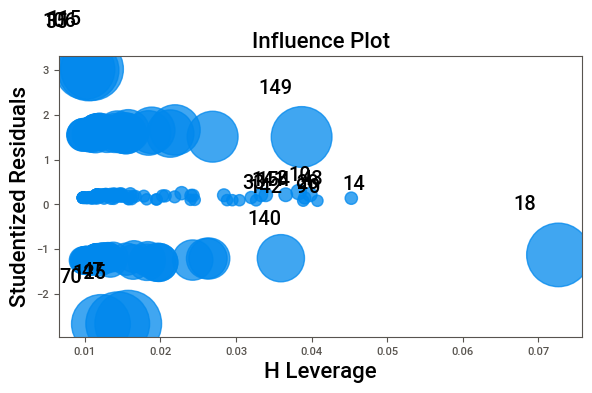

In [148]:
fig = sm.graphics.influence_plot(prestige_model, criterion="cooks")
fig.tight_layout(pad=1.0)